In [101]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import h5py
import matplotlib.pyplot as plt
import matplotlib.dates as md
from scipy.optimize import leastsq,curve_fit
import math
import time
import datetime as dt
import pandas as pd
from sympy import Symbol
from sympy.solvers import solve
import sympy as sp

In [102]:
def open_data(exp_id):
    ## basic paths
    data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
    analysis_local_path='D:/Analysis/' # D:\ is local SSD in the main experiment computer
    analysis_master_path='Y:/Analysis/' # Y:\ is network drive connected to Hexagon E:\Rb\
    experiment_file='results.hdf5'
    qdp_name='qdp.txt'

    exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
    exp_path=data_master_path+exp_date+'/'+exp_id+'/'
    analysis_path=analysis_master_path+exp_date+'/'+exp_id+'/'

    if not os.path.exists(analysis_path):
        os.makedirs(analysis_path)

    if os.path.isfile(analysis_path+qdp_name):
        print "Yay! found old qdp class. We can save time!"
        q = qdp.load_qdp(filename=analysis_path+qdp_name)
    else:
        print "Coudn't find processed qdp. Loading and saving"
        q = qdp.QDP(base_data_path=exp_path)
        q.load_data_file(experiment_file)
        q.save_qdp(filename=analysis_path+qdp_name)
    return q

def process_container(exp_id):
    q=open_data(exp_id)
    cuts=[[450],[450],[450]]
    for r in range(5):
        q.set_thresholds(cuts, roi=r)
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
    retention = q.apply_thresholds()
    
    e=0
    timestamp=[]
    xdata=[]
    reten={}
    err={}
    container={}
    for i in q.experiments[e]['iterations']:
        iter_timestamp=q.experiments[e]['iterations'][i]['timestamp_iteration']
        timestamp.append(iter_timestamp)
        xdata.append(np.squeeze(retention['ivar'])[i][0])
        for roi in [0,1,2,3,4]:
            if i==0:
                reten[str(roi)]=[]
                err[str(roi)]=[]
            reten[str(roi)].append(np.squeeze(retention['retention'])[i][roi])
            err[str(roi)].append(np.squeeze(retention['error'])[e][roi])

    dates=[dt.datetime.fromtimestamp(ts) for ts in timestamp]
    container['exp_id']=exp_id
    container['timestamps']=timestamp
    container['datetime']=dates
    container['xdata']=xdata
    container['retentions']=reten
    container['errors']=err
    container['qdp_class']=q
    return container

def flatten(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list


def sin(t,amp,freq,phase,offset):
    res = (amp*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def decaying_sin(t,tau,amp,freq,phase,offset):
    res = (amp*np.exp(-t/tau)*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def est_freq(ydata,tgap,tau,amp,freq,phase,offset): # Estimation of frequency change (from dy/df where y=sinusoidal fit)
    res=(ydata-decaying_sin(tau,tgap,amp,freq,phase,offset))/(amp*np.exp(-tgap/tau)*2*np.pi*tgap*np.cos(2*np.pi*freq*tgap+phase))
    return res

def gaussian(x,amp,x0,sigma,offset):
    res=(amp*np.exp((-2.0*(x-x0)**2)/(sigma**2)))+offset
    return res


# Set experiment(s) to analyze


In [103]:
# exp_ids=['2018_04_16_20_20_44_again, 780A Ramsey',
#          '2018_04_16_20_49_58_again, 780A Ramsey',
#          '2018_04_16_21_23_58_again, 780A Ramsey',
#          '2018_04_16_21_48_55_again, 780A Ramsey',
#          '2018_04_16_22_11_57_again, 780A Ramsey',
#          '2018_04_16_22_49_47_again, 780A Ramsey'
#         ]

# Closed Loop dataset
exp_ids=['2018_04_17_10_58_11_780A Ramsey between r1-r2',
         '2018_04_17_11_26_58_780A Ramsey between r1-r2',
         '2018_04_17_12_16_21_780A Ramsey between r1-r2',
         '2018_04_17_12_52_32_780A Ramsey between r1-r2',
         '2018_04_17_16_21_34_780A ramsey',
         '2018_04_17_21_12_34_780A ramsey',
         '2018_04_17_21_56_12_780A ramsey',
         '2018_04_17_22_53_53_780A ramsey',
         '2018_04_18_09_49_23_780A ramsey',
         '2018_04_18_09_49_23_780A ramsey',
         '2018_04_18_10_54_00_780A ramsey',
         '2018_04_18_11_42_28_780A ramsey',
         '2018_04_18_19_49_00_780A ramsey, closed loop',
         '2018_04_18_20_29_56_780A ramsey, closed loop',
         '2018_04_18_21_20_52_780A ramsey, closed loop',
         '2018_04_18_22_11_27_780A ramsey, closed loop',
         '2018_04_19_11_01_05_780A ramsey, closed loop',
         '2018_04_19_15_18_27_780A ramsey, closed loop',
         '2018_04_19_15_43_07_780A ramsey, closed loop',
         '2018_04_19_16_03_22_780A ramsey, closed loop',
         '2018_04_19_16_23_37_780A ramsey, closed loop',
         '2018_04_19_16_46_21_780A ramsey, closed loop',
         '2018_04_19_17_30_17_780A ramsey, closed loop',
         '2018_04_19_22_47_43_780A ramsey, closed loop',
         '2018_04_19_23_20_45_780A ramsey, closed loop',
         '2018_04_19_23_50_26_780A ramsey, closed loop',
         '2018_04_20_00_18_45_780A ramsey, closed loop',
         '2018_04_20_00_44_51_780A ramsey, closed loop',
#          '2018_04_20_02_03_45_780A ramsey, closed loop',
         '2018_04_20_08_32_02_780A ramsey, closed loop',
         '2018_04_20_09_20_41_780A ramsey, closed loop',
         '2018_04_20_10_49_28_780A ramsey, closed loop',
         '2018_04_20_11_47_15_780A ramsey, closed loop',
         '2018_04_20_12_26_31_780A ramsey, closed loop',
         '2018_04_20_13_07_25_780A ramsey, closed loop',
         '2018_04_20_13_49_08_780A ramsey, closed loop',
         '2018_04_20_14_27_42_780A ramsey, closed loop',
         '2018_04_20_14_51_43_780A ramsey, closed loop',
         '2018_04_20_15_21_04_780A ramsey, closed loop',
         '2018_04_20_15_44_45_780A ramsey, closed loop',
         '2018_04_20_16_05_33_780A ramsey, closed loop',
         '2018_04_20_16_23_49_780A ramsey, closed loop',
         '2018_04_20_16_40_40_780A ramsey, closed loop',
         '2018_04_20_17_23_53_780A ramsey, closed loop',
         '2018_04_20_18_10_59_780A ramsey, closed loop',
         '2018_04_20_19_40_13_780A ramsey, closed loop',
         '2018_04_20_20_20_52_780A ramsey, closed loop',
         '2018_04_21_14_01_47_780A ramsey, closed loop',
         '2018_04_21_14_39_59_780A ramsey, closed loop',
         '2018_04_21_15_14_06_780A ramsey, closed loop',
         '2018_04_21_15_47_33_780A ramsey, closed loop',
         '2018_04_21_18_53_41_780A ramsey, closed loop',
         '2018_04_21_19_12_49_780A ramsey, closed loop',
         '2018_04_21_19_33_26_780A ramsey, closed loop',
         '2018_04_21_19_55_13_780A ramsey, closed loop',
         '2018_04_21_20_16_19_780A ramsey, closed loop',
         '2018_04_21_20_36_32_780A ramsey, closed loop'        
         
        ]
assorted={}
assorted['qdp_class']=[]
assorted['exp_ids']=[]
assorted['timestamps']=[]
assorted['retentions']=[[],[],[],[],[]]
assorted['errors']=[[],[],[],[],[]]
for exp_id in exp_ids:
    container=process_container(exp_id)
    assorted['qdp_class'].append(container['qdp_class'])
    assorted['exp_ids'].append(container['exp_id'])
    assorted['timestamps'].append(container['timestamps'])
    for roi in [0,1,2,3,4]:
        assorted['retentions'][roi].append(container['retentions'][str(roi)])
        assorted['errors'][roi].append(container['errors'][str(roi)])

Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_17/2018_04_17_10_58_11_780A Ramsey between r1-r2/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_17/2018_04_17_11_26_58_780A Ramsey between r1-r2/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_17/2018_04_17_12_16_21_780A Ramsey between r1-r2/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_17/2018_04_17_12_52_32_780A Ramsey between r1-r2/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_17/2018_04_17_16_21_34_780A ramsey/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_17/2018_04_17_21_12_34_780A ramsey/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_17/2018_04_17_21_56_12_780A ramsey/qdp.txt

In [85]:
exp_ids[46]

'2018_04_20_21_13_28_780A ramsey, closed loop'

# Experiment-wise analysis

2018_04_17_10_58_11_780A Ramsey between r1-r2
0


<IPython.core.display.Javascript object>


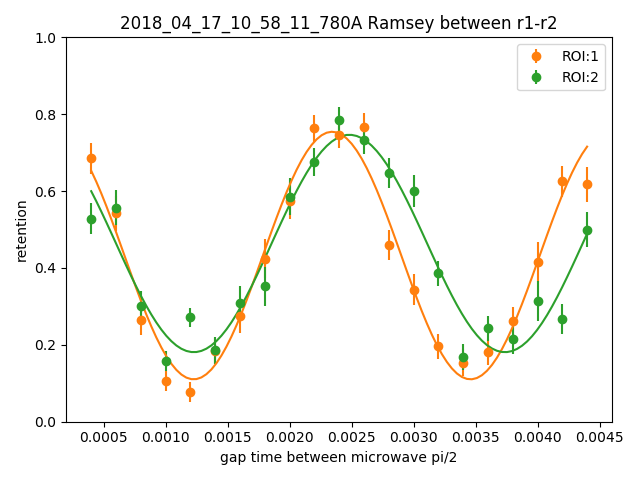

tau 1  is  -220855.421318  with 1 std of   853981957579.0
amplitude 1  is  0.322032515499  with 1 std of   0.0211562521756
frequency 1  is  447.8261683  with 1 std of   6.7919487441
phase 1  is  1.26112501959  with 1 std of   0.11166254174
offset 1  is  0.432322179413  with 1 std of   0.0125034805495
tau 2  is  2937.87022183  with 1 std of   294476914.475
amplitude 2  is  0.282774035903  with 1 std of   0.0511578867859
frequency 2  is  398.539483307  with 1 std of   8.63485347622
phase 2  is  1.63797205095  with 1 std of   0.145840061838
offset 2  is  0.463711595699  with 1 std of   0.0151060661148
2018_04_17_11_26_58_780A Ramsey between r1-r2
1


<IPython.core.display.Javascript object>


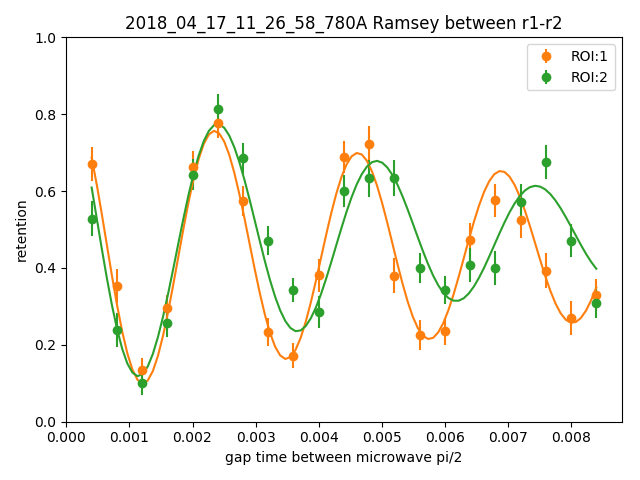

tau 1  is  0.0111551193792  with 1 std of   0.00257857008951
amplitude 1  is  0.385223779816  with 1 std of   0.0330754912705
frequency 1  is  440.528210665  with 1 std of   3.14859851341
phase 1  is  1.3244603664  with 1 std of   0.0800967671752
offset 1  is  0.444836780473  with 1 std of   0.00891418923851
tau 2  is  0.00643763704134  with 1 std of   0.00179521541582
amplitude 2  is  0.430466865377  with 1 std of   0.0665672228133
frequency 2  is  396.694209955  with 1 std of   5.91807847684
phase 2  is  1.81531441562  with 1 std of   0.125123998963
offset 2  is  0.478526661926  with 1 std of   0.0146787041882
2018_04_17_12_16_21_780A Ramsey between r1-r2
2


<IPython.core.display.Javascript object>


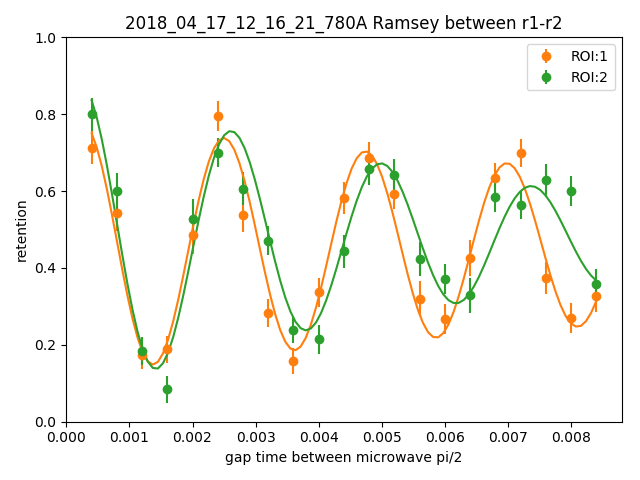

tau 1  is  0.0172453142321  with 1 std of   0.00768063035819
amplitude 1  is  0.329626895453  with 1 std of   0.0374818403605
frequency 1  is  445.846283587  with 1 std of   4.34969869663
phase 1  is  0.843879708006  with 1 std of   0.121006998508
offset 1  is  0.453026267458  with 1 std of   0.0115664397346
tau 2  is  0.00672219193011  with 1 std of   0.00187448577525
amplitude 2  is  0.416732604583  with 1 std of   0.0605309230354
frequency 2  is  420.358666048  with 1 std of   6.93961979057
phase 2  is  0.911685255128  with 1 std of   0.156283882569
offset 2  is  0.474106427453  with 1 std of   0.0155071496377
2018_04_17_12_52_32_780A Ramsey between r1-r2
3


<IPython.core.display.Javascript object>


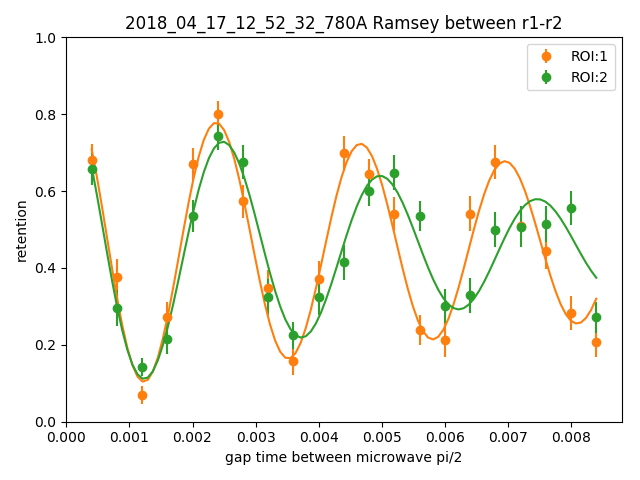

tau 1  is  0.0122500099877  with 1 std of   0.00436372814621
amplitude 1  is  0.390257258883  with 1 std of   0.0483127816333
frequency 1  is  436.720490681  with 1 std of   4.53776953793
phase 1  is  1.31416616499  with 1 std of   0.116946971641
offset 1  is  0.456774524526  with 1 std of   0.0133252090978
tau 2  is  0.00651239819389  with 1 std of   0.00159492932787
amplitude 2  is  0.409351216124  with 1 std of   0.0547603676453
frequency 2  is  401.167243906  with 1 std of   5.30917603867
phase 2  is  1.54397498171  with 1 std of   0.114446324645
offset 2  is  0.449407112982  with 1 std of   0.0124110797706
2018_04_17_16_21_34_780A ramsey
4


<IPython.core.display.Javascript object>


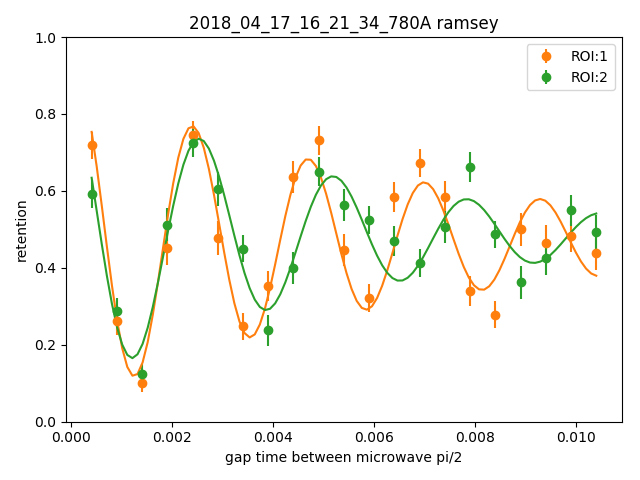

tau 1  is  0.00681548383517  with 1 std of   0.00167999787516
amplitude 1  is  0.423757242821  with 1 std of   0.0615950923511
frequency 1  is  435.196787703  with 1 std of   5.84478818283
phase 1  is  1.2616611167  with 1 std of   0.143319937298
offset 1  is  0.470743860079  with 1 std of   0.014570827752
tau 2  is  0.0053702533996  with 1 std of   0.0012547862999
amplitude 2  is  0.401959098594  with 1 std of   0.0636495114145
frequency 2  is  377.096032072  with 1 std of   6.38894299733
phase 2  is  1.7839250711  with 1 std of   0.132117196347
offset 2  is  0.485561302473  with 1 std of   0.0128329519655
2018_04_17_21_12_34_780A ramsey
5


<IPython.core.display.Javascript object>


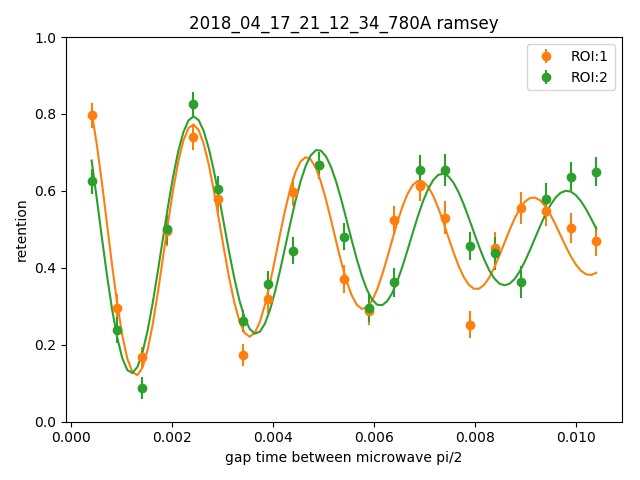

tau 1  is  0.00670930479312  with 1 std of   0.00116882008489
amplitude 1  is  0.428806207569  with 1 std of   0.0437144538975
frequency 1  is  445.022892559  with 1 std of   4.36432344903
phase 1  is  1.06689516956  with 1 std of   0.10759250644
offset 1  is  0.473903855815  with 1 std of   0.010636341237
tau 2  is  0.00740544814011  with 1 std of   0.00221681155353
amplitude 2  is  0.42506265622  with 1 std of   0.0715285579279
frequency 2  is  405.767587965  with 1 std of   5.73732708973
phase 2  is  1.62702878649  with 1 std of   0.145840177365
offset 2  is  0.487762924533  with 1 std of   0.0163444897786
2018_04_17_21_56_12_780A ramsey
6


<IPython.core.display.Javascript object>


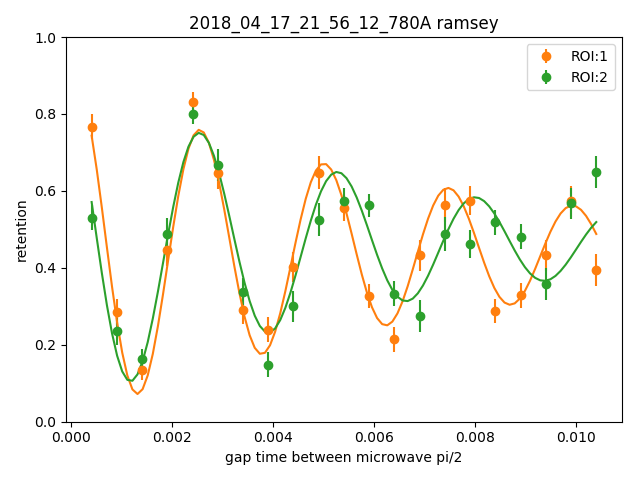

tau 1  is  0.00754228812983  with 1 std of   0.00141524519533
amplitude 1  is  0.442444156627  with 1 std of   0.0456170213078
frequency 1  is  406.137826815  with 1 std of   3.81634899821
phase 1  is  1.32421385444  with 1 std of   0.0993965105769
offset 1  is  0.44355762426  with 1 std of   0.0110040903466
tau 2  is  0.00627155865606  with 1 std of   0.00186732486722
amplitude 2  is  0.432469302137  with 1 std of   0.0807137481571
frequency 2  is  366.169543091  with 1 std of   6.68982756168
phase 2  is  1.95192104877  with 1 std of   0.152259417251
offset 2  is  0.463117587104  with 1 std of   0.0170862721505
2018_04_17_22_53_53_780A ramsey
7


<IPython.core.display.Javascript object>


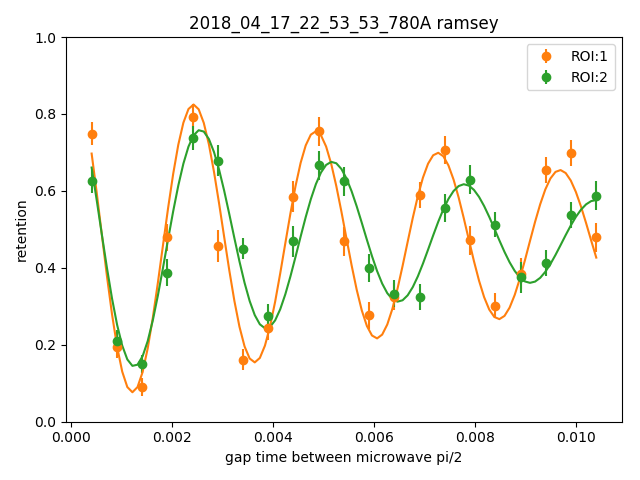

tau 1  is  0.0110498091872  with 1 std of   0.00262214448971
amplitude 1  is  0.440334093626  with 1 std of   0.0449272714859
frequency 1  is  413.097470112  with 1 std of   3.05720806876
phase 1  is  1.54212895515  with 1 std of   0.091413156399
offset 1  is  0.471112567546  with 1 std of   0.0115959022358
tau 2  is  0.0074810654558  with 1 std of   0.00136728248226
amplitude 2  is  0.394984442183  with 1 std of   0.0414198457814
frequency 2  is  382.357289365  with 1 std of   3.75653516565
phase 2  is  1.67069841601  with 1 std of   0.0933201297176
offset 2  is  0.478066358544  with 1 std of   0.00968955335737
2018_04_18_09_49_23_780A ramsey
8


<IPython.core.display.Javascript object>


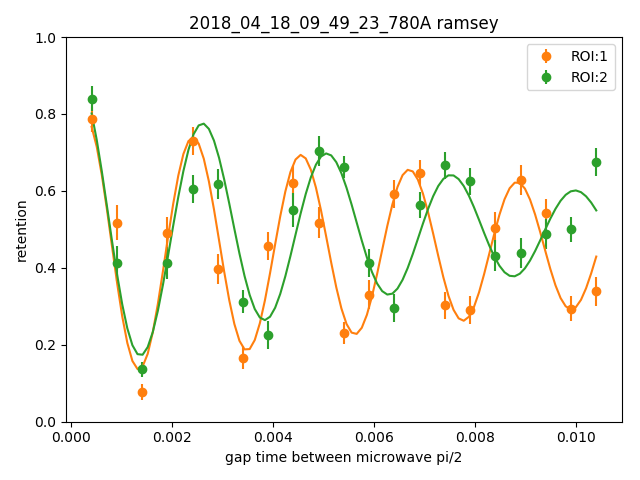

tau 1  is  0.0125078155135  with 1 std of   0.00501442187643
amplitude 1  is  0.350038115948  with 1 std of   0.0531782555533
frequency 1  is  466.888625911  with 1 std of   5.19579563841
phase 1  is  0.767588803548  with 1 std of   0.165486011587
offset 1  is  0.450534151969  with 1 std of   0.0156025889063
tau 2  is  0.00744233756371  with 1 std of   0.00224616435696
amplitude 2  is  0.392898193847  with 1 std of   0.0651446413922
frequency 2  is  406.374981377  with 1 std of   6.50956915718
phase 2  is  1.17138246627  with 1 std of   0.16980166006
offset 2  is  0.498705151037  with 1 std of   0.0161257398936
2018_04_18_09_49_23_780A ramsey
9


<IPython.core.display.Javascript object>


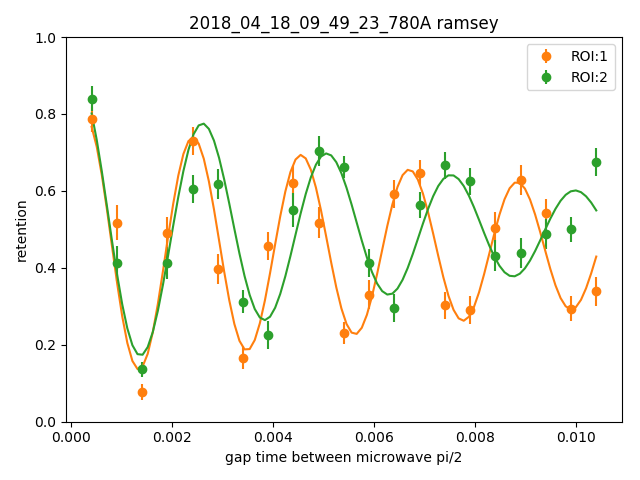

tau 1  is  0.0125078155135  with 1 std of   0.00501442187643
amplitude 1  is  0.350038115948  with 1 std of   0.0531782555533
frequency 1  is  466.888625911  with 1 std of   5.19579563841
phase 1  is  0.767588803548  with 1 std of   0.165486011587
offset 1  is  0.450534151969  with 1 std of   0.0156025889063
tau 2  is  0.00744233756371  with 1 std of   0.00224616435696
amplitude 2  is  0.392898193847  with 1 std of   0.0651446413922
frequency 2  is  406.374981377  with 1 std of   6.50956915718
phase 2  is  1.17138246627  with 1 std of   0.16980166006
offset 2  is  0.498705151037  with 1 std of   0.0161257398936
2018_04_18_10_54_00_780A ramsey
10


<IPython.core.display.Javascript object>


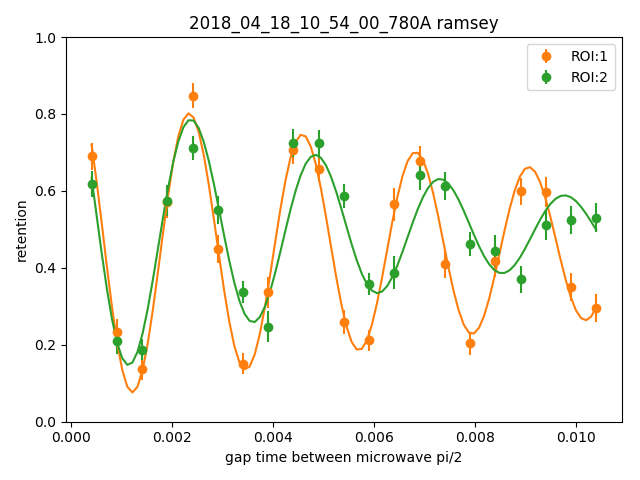

tau 1  is  0.0130992727787  with 1 std of   0.00179520985891
amplitude 1  is  0.415178278965  with 1 std of   0.0218950926818
frequency 1  is  445.566218256  with 1 std of   1.67369436372
phase 1  is  1.30468559336  with 1 std of   0.0514712729991
offset 1  is  0.454474635919  with 1 std of   0.006095302615
tau 2  is  0.00644902913238  with 1 std of   0.00162538144535
amplitude 2  is  0.417550491056  with 1 std of   0.0641780057495
frequency 2  is  405.311746499  with 1 std of   5.4177173937
phase 2  is  1.76991719807  with 1 std of   0.127264626776
offset 2  is  0.496938434102  with 1 std of   0.0137354570773
2018_04_18_11_42_28_780A ramsey
11


<IPython.core.display.Javascript object>


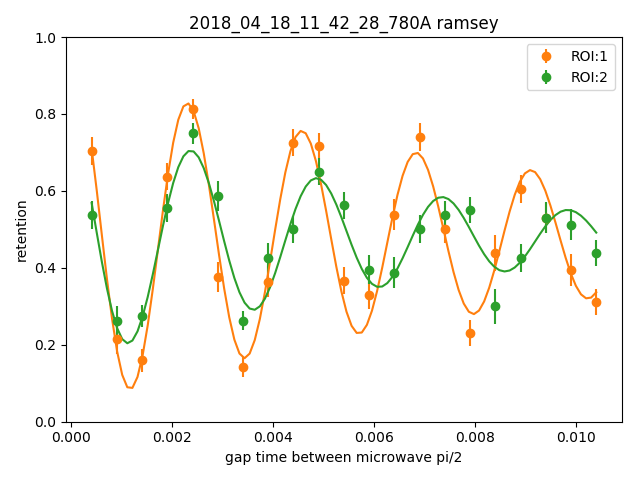

tau 1  is  0.00992893125737  with 1 std of   0.00182891977745
amplitude 1  is  0.441861565222  with 1 std of   0.0386707442176
frequency 1  is  441.030848848  with 1 std of   2.91162388032
phase 1  is  1.45378893811  with 1 std of   0.0819119248463
offset 1  is  0.477653459925  with 1 std of   0.00994107026889
tau 2  is  0.00654498428706  with 1 std of   0.00174487185727
amplitude 2  is  0.326019702778  with 1 std of   0.0527656864033
frequency 2  is  401.533591487  with 1 std of   5.64239098896
phase 2  is  1.83329690817  with 1 std of   0.132922914685
offset 2  is  0.47825056715  with 1 std of   0.0113235223841
2018_04_18_19_49_00_780A ramsey, closed loop
12


<IPython.core.display.Javascript object>


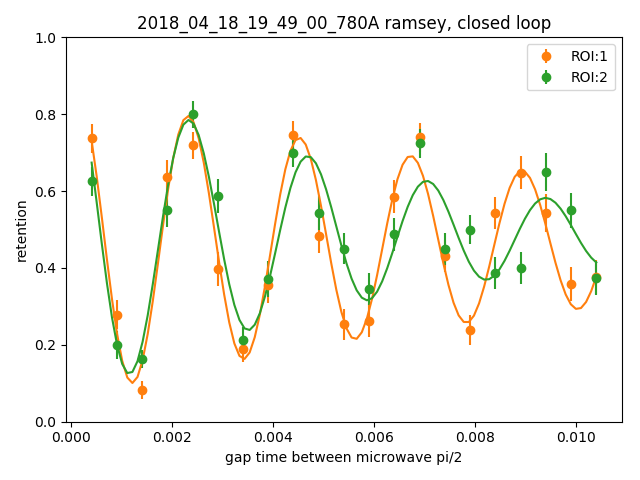

tau 1  is  0.0117583200481  with 1 std of   0.00317714304181
amplitude 1  is  0.403148870938  with 1 std of   0.0446695386584
frequency 1  is  453.186220007  with 1 std of   3.55284702381
phase 1  is  1.25087869867  with 1 std of   0.108028630386
offset 1  is  0.464426641699  with 1 std of   0.012167046146
tau 2  is  0.00625444359306  with 1 std of   0.00171899497351
amplitude 2  is  0.434714342779  with 1 std of   0.0746161449808
frequency 2  is  424.330569044  with 1 std of   6.51349311603
phase 2  is  1.59521713415  with 1 std of   0.14992758322
offset 2  is  0.485845368275  with 1 std of   0.0161894667326
2018_04_18_20_29_56_780A ramsey, closed loop
13


<IPython.core.display.Javascript object>


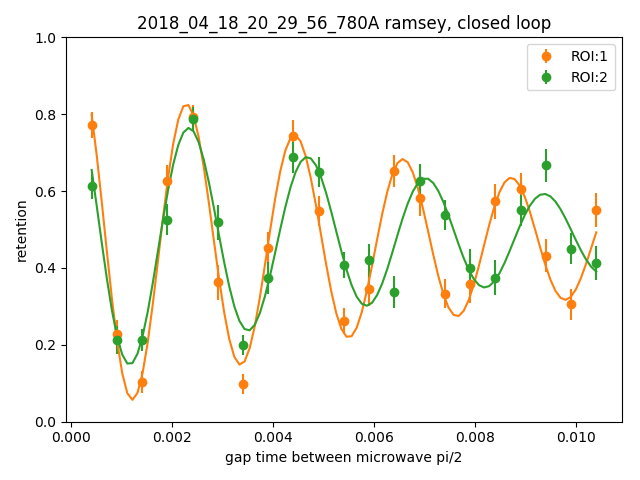

tau 1  is  0.00849335723269  with 1 std of   0.000901283885382
amplitude 1  is  0.471778508519  with 1 std of   0.025284718191
frequency 1  is  466.331169551  with 1 std of   1.93455850561
phase 1  is  1.13813362355  with 1 std of   0.0535984461118
offset 1  is  0.465866029792  with 1 std of   0.00646869115446
tau 2  is  0.00759161892925  with 1 std of   0.00185780318133
amplitude 2  is  0.386361756439  with 1 std of   0.0533127578304
frequency 2  is  426.339000264  with 1 std of   4.86407168778
phase 2  is  1.57356995975  with 1 std of   0.123177647615
offset 2  is  0.480328807906  with 1 std of   0.0124691108958
2018_04_18_21_20_52_780A ramsey, closed loop
14


<IPython.core.display.Javascript object>


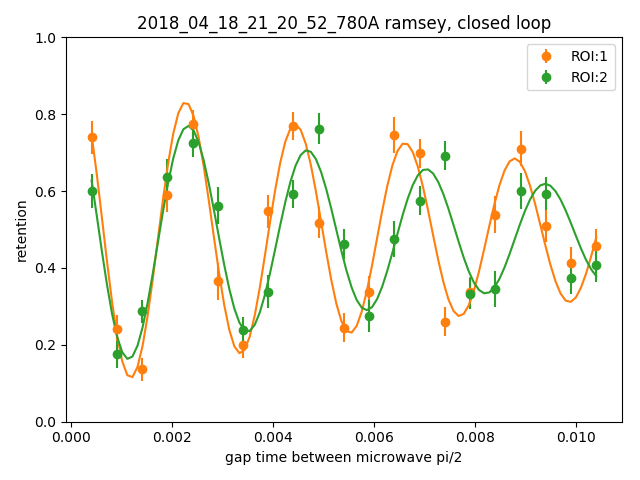

tau 1  is  0.0116769281591  with 1 std of   0.00311290267936
amplitude 1  is  0.415169772585  with 1 std of   0.0452881856029
frequency 1  is  460.104378828  with 1 std of   3.40338111452
phase 1  is  1.29131395269  with 1 std of   0.104113714376
offset 1  is  0.489442036707  with 1 std of   0.0122168016523
tau 2  is  0.00938592328426  with 1 std of   0.00318201657705
amplitude 2  is  0.364047569882  with 1 std of   0.0610563492843
frequency 2  is  424.007819462  with 1 std of   5.39422347119
phase 2  is  1.65712328902  with 1 std of   0.148428271233
offset 2  is  0.485296632157  with 1 std of   0.0151026333992
2018_04_18_22_11_27_780A ramsey, closed loop
15


<IPython.core.display.Javascript object>


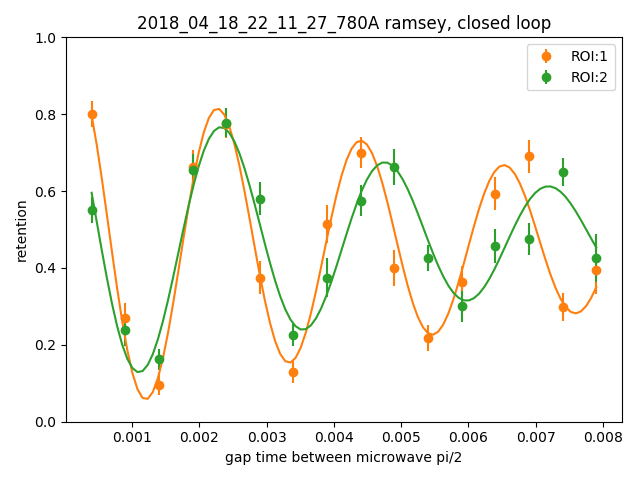

tau 1  is  0.00790136170965  with 1 std of   0.00221276461584
amplitude 1  is  0.470791878535  with 1 std of   0.0594544093763
frequency 1  is  469.740761372  with 1 std of   5.67353565864
phase 1  is  1.11465969111  with 1 std of   0.128650108928
offset 1  is  0.46184889208  with 1 std of   0.0157899280256
tau 2  is  0.00638510244185  with 1 std of   0.00197547789829
amplitude 2  is  0.415998525573  with 1 std of   0.068455556926
frequency 2  is  410.868019202  with 1 std of   6.36374544613
phase 2  is  1.80279733692  with 1 std of   0.1304715693
offset 2  is  0.477852106141  with 1 std of   0.0152855928418
2018_04_19_11_01_05_780A ramsey, closed loop
16


<IPython.core.display.Javascript object>


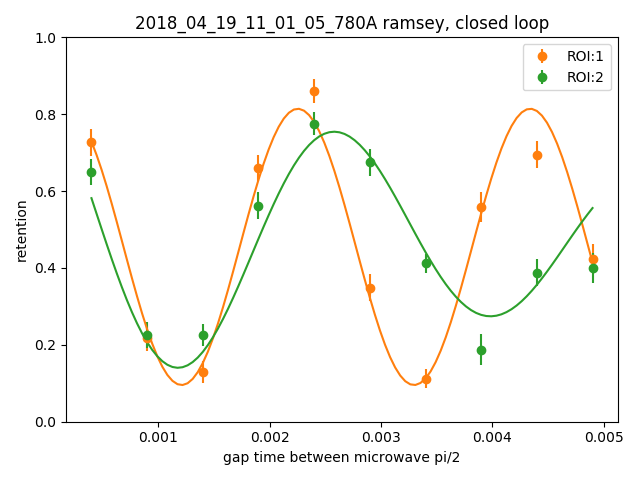

tau 1  is  -320548.573876  with 1 std of   2.63850616933e+12
amplitude 1  is  0.3594266024  with 1 std of   0.0500815890691
frequency 1  is  479.107006542  with 1 std of   8.8240151014
phase 1  is  1.07086915812  with 1 std of   0.176212034093
offset 1  is  0.454809133564  with 1 std of   0.0250356948974
tau 2  is  0.00570139334869  with 1 std of   0.00471315929202
amplitude 2  is  0.424999456112  with 1 std of   0.151665721362
frequency 2  is  356.37450429  with 1 std of   17.808133188
phase 2  is  1.99953960809  with 1 std of   0.257722613309
offset 2  is  0.484979578199  with 1 std of   0.0349130039736
2018_04_19_15_18_27_780A ramsey, closed loop
17


<IPython.core.display.Javascript object>


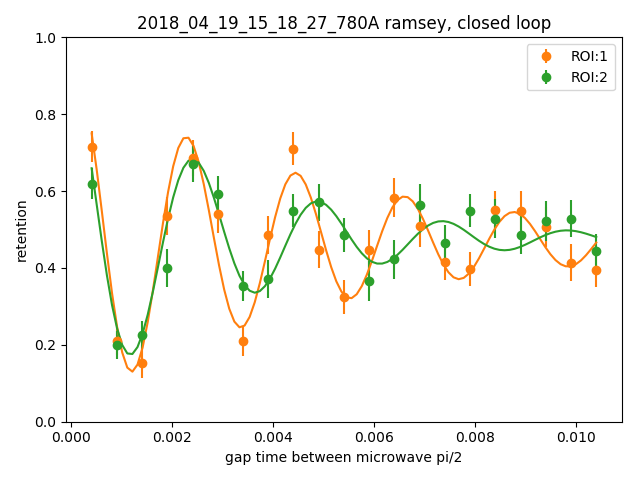

tau 1  is  0.00518697841236  with 1 std of   0.00105104870415
amplitude 1  is  0.425517029752  with 1 std of   0.0562053364026
frequency 1  is  462.415608482  with 1 std of   6.09377494294
phase 1  is  1.17857572514  with 1 std of   0.131084823441
offset 1  is  0.467304868845  with 1 std of   0.0120409917565
tau 2  is  0.00324495406896  with 1 std of   0.000764146122168
amplitude 2  is  0.436302012126  with 1 std of   0.0805982321475
frequency 2  is  404.563653499  with 1 std of   10.2917485603
phase 2  is  1.63164724481  with 1 std of   0.148142393453
offset 2  is  0.476837196984  with 1 std of   0.0122359312884
2018_04_19_15_43_07_780A ramsey, closed loop
18


<IPython.core.display.Javascript object>


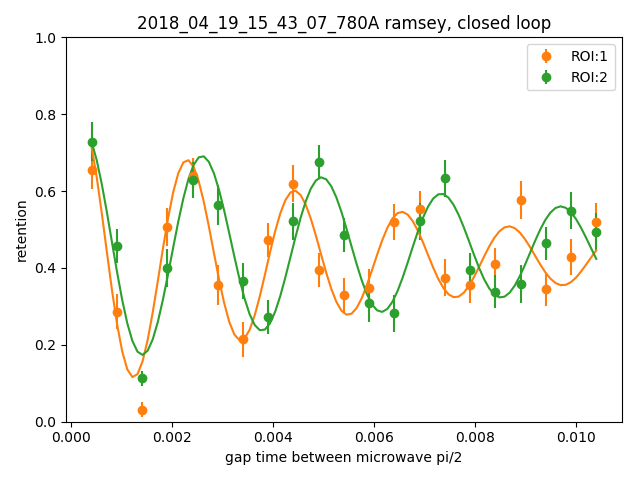

tau 1  is  0.00570130623621  with 1 std of   0.00142165402897
amplitude 1  is  0.384187473732  with 1 std of   0.0592972917828
frequency 1  is  470.528630218  with 1 std of   7.08098214397
phase 1  is  1.01599512065  with 1 std of   0.16310601286
offset 1  is  0.424541210872  with 1 std of   0.0136672439429
tau 2  is  0.00910879152599  with 1 std of   0.00238928544489
amplitude 2  is  0.321833426511  with 1 std of   0.0401803513271
frequency 2  is  421.981192174  with 1 std of   4.60928095942
phase 2  is  0.95298823854  with 1 std of   0.133391893484
offset 2  is  0.449399655879  with 1 std of   0.0108031534658
2018_04_19_16_03_22_780A ramsey, closed loop
19


<IPython.core.display.Javascript object>


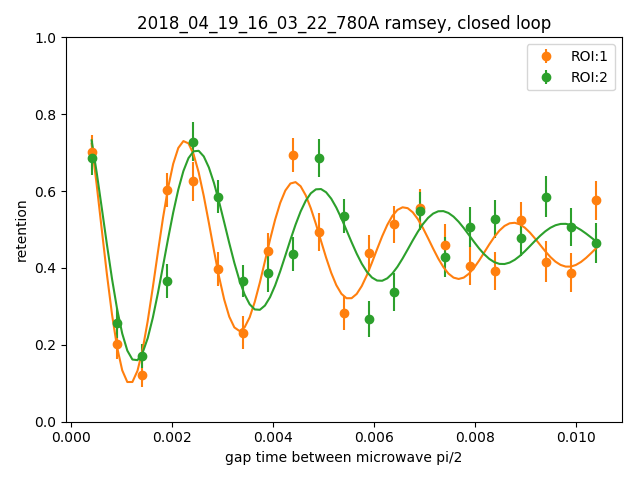

tau 1  is  0.004456506572  with 1 std of   0.000888253836221
amplitude 1  is  0.460167463355  with 1 std of   0.063851475708
frequency 1  is  460.490438129  with 1 std of   6.8305442866
phase 1  is  1.28720036264  with 1 std of   0.131179856596
offset 1  is  0.453436689283  with 1 std of   0.012461410194
tau 2  is  0.00440626856093  with 1 std of   0.00127539126463
amplitude 2  is  0.416692194698  with 1 std of   0.0844256961335
frequency 2  is  412.447147973  with 1 std of   10.0006769058
phase 2  is  1.34447669472  with 1 std of   0.191146991221
offset 2  is  0.469688070862  with 1 std of   0.0163064971786
2018_04_19_16_23_37_780A ramsey, closed loop
20


<IPython.core.display.Javascript object>


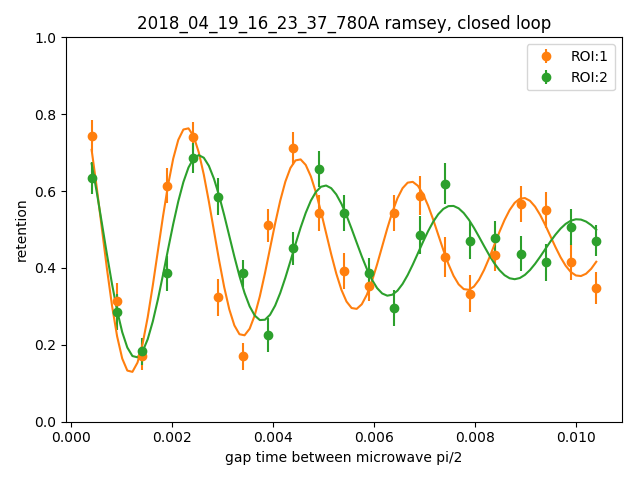

tau 1  is  0.0068239695684  with 1 std of   0.00149805461665
amplitude 1  is  0.409458450022  with 1 std of   0.0527240465505
frequency 1  is  449.617404065  with 1 std of   4.93414242689
phase 1  is  1.35687800715  with 1 std of   0.121053756977
offset 1  is  0.472189084228  with 1 std of   0.0121801456664
tau 2  is  0.00616795644488  with 1 std of   0.00123395772251
amplitude 2  is  0.357542168609  with 1 std of   0.0443665249065
frequency 2  is  399.910907207  with 1 std of   4.97300961591
phase 2  is  1.4411692844  with 1 std of   0.115372588939
offset 2  is  0.456713547422  with 1 std of   0.00983838032337
2018_04_19_16_46_21_780A ramsey, closed loop
21


<IPython.core.display.Javascript object>


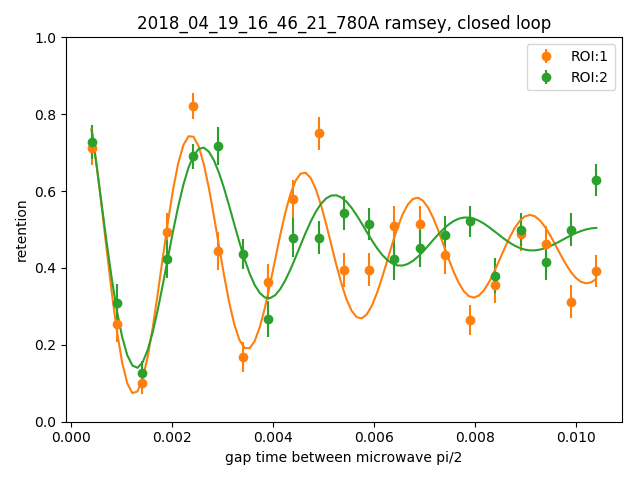

tau 1  is  0.00590021634578  with 1 std of   0.00138196148855
amplitude 1  is  0.455266906315  with 1 std of   0.0666456297368
frequency 1  is  446.265102041  with 1 std of   6.47678981263
phase 1  is  1.16643192771  with 1 std of   0.148683348298
offset 1  is  0.440636564123  with 1 std of   0.0151726108619
tau 2  is  0.00344476041079  with 1 std of   0.000715825271479
amplitude 2  is  0.498556372412  with 1 std of   0.0794618838244
frequency 2  is  382.446923354  with 1 std of   9.20452508223
phase 2  is  1.49926502484  with 1 std of   0.142305373721
offset 2  is  0.480448797367  with 1 std of   0.0131416864014
2018_04_19_17_30_17_780A ramsey, closed loop
22


<IPython.core.display.Javascript object>


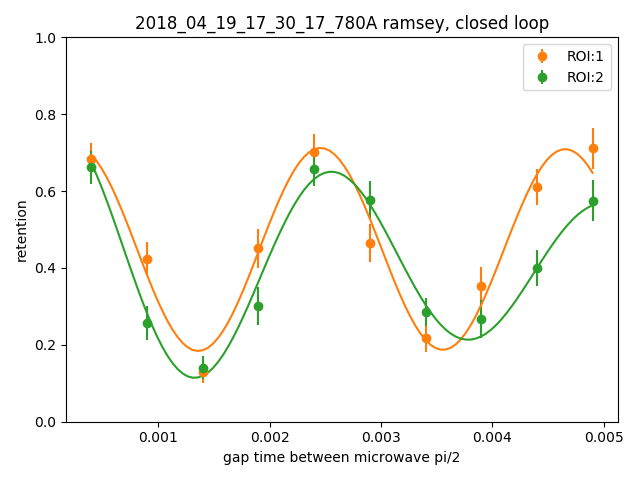

tau 1  is  0.188482193352  with 1 std of   2.40177550178
amplitude 1  is  0.266772772061  with 1 std of   0.0529257193607
frequency 1  is  455.04689019  with 1 std of   12.5480071117
phase 1  is  0.826673217129  with 1 std of   0.235052058751
offset 1  is  0.448927194536  with 1 std of   0.0191961216483
tau 2  is  0.00601191271186  with 1 std of   0.00199605970796
amplitude 2  is  0.36903304759  with 1 std of   0.0512498952792
frequency 2  is  407.054742593  with 1 std of   10.2310308939
phase 2  is  1.25513628155  with 1 std of   0.152103007125
offset 2  is  0.409620140906  with 1 std of   0.0145933845107
2018_04_19_22_47_43_780A ramsey, closed loop
23


<IPython.core.display.Javascript object>


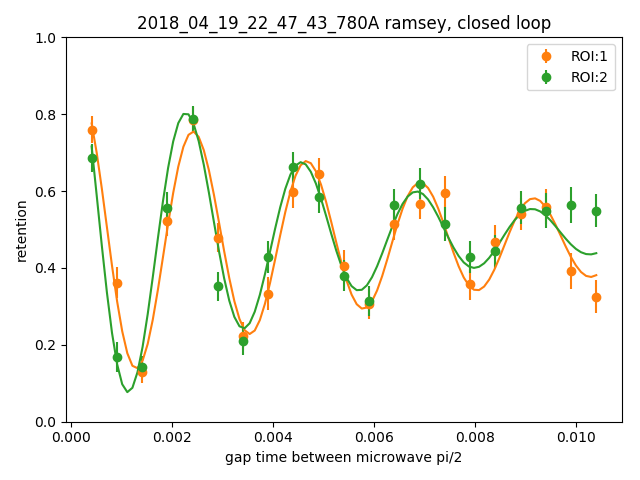

tau 1  is  0.00714776669659  with 1 std of   0.0012168831746
amplitude 1  is  0.398497912809  with 1 std of   0.038511995438
frequency 1  is  444.30631461  with 1 std of   4.00062945593
phase 1  is  1.08144904487  with 1 std of   0.101406618761
offset 1  is  0.470915888079  with 1 std of   0.00954204367892
tau 2  is  0.00441340211202  with 1 std of   0.000793107173868
amplitude 2  is  0.530501559983  with 1 std of   0.0687232541592
frequency 2  is  437.278387749  with 1 std of   6.06539511587
phase 2  is  1.54990828909  with 1 std of   0.111446418505
offset 2  is  0.486776992709  with 1 std of   0.0127744437916
2018_04_19_23_20_45_780A ramsey, closed loop
24


<IPython.core.display.Javascript object>


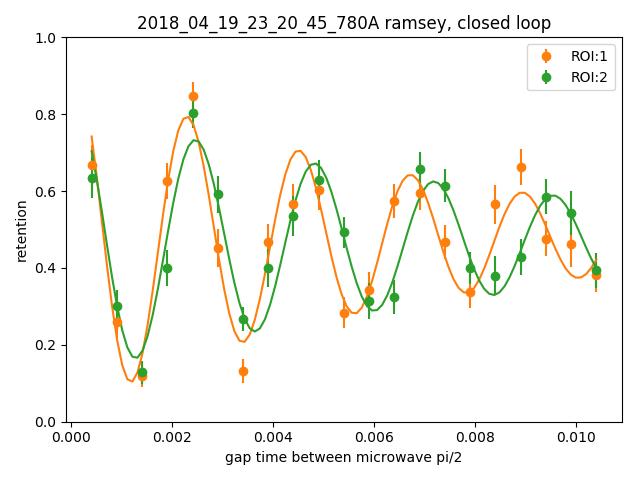

tau 1  is  0.00684926631075  with 1 std of   0.00158401338019
amplitude 1  is  0.444075138402  with 1 std of   0.0598625605314
frequency 1  is  451.351135515  with 1 std of   5.18804376913
phase 1  is  1.3205539952  with 1 std of   0.128084155118
offset 1  is  0.47642985749  with 1 std of   0.0139186260486
tau 2  is  0.00904146139452  with 1 std of   0.00247741983264
amplitude 2  is  0.348764445662  with 1 std of   0.0470705103003
frequency 2  is  423.080416066  with 1 std of   4.63755787003
phase 2  is  1.29335544106  with 1 std of   0.130296728835
offset 2  is  0.46774696808  with 1 std of   0.0119992952297
2018_04_19_23_50_26_780A ramsey, closed loop
25


<IPython.core.display.Javascript object>


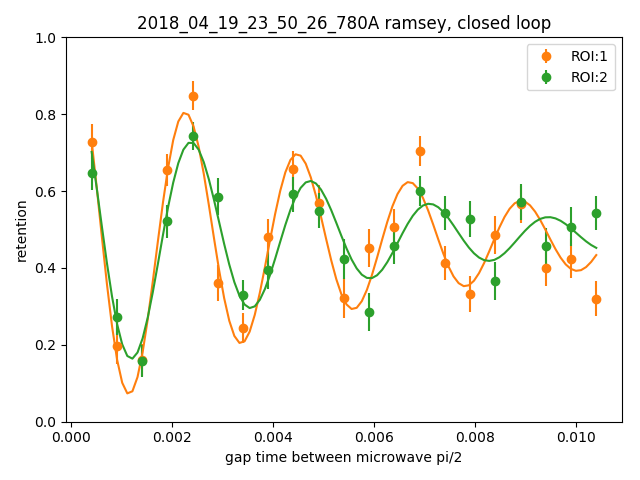

tau 1  is  0.00558997773255  with 1 std of   0.00112877485052
amplitude 1  is  0.494868237023  with 1 std of   0.0647107880144
frequency 1  is  450.40350007  with 1 std of   5.425593937
phase 1  is  1.42141930625  with 1 std of   0.118907830631
offset 1  is  0.474624845055  with 1 std of   0.0136798800795
tau 2  is  0.00443115784524  with 1 std of   0.00104321683622
amplitude 2  is  0.418895776906  with 1 std of   0.0701482599928
frequency 2  is  423.526301844  with 1 std of   7.92716126566
phase 2  is  1.46820990414  with 1 std of   0.148777618829
offset 2  is  0.482903486094  with 1 std of   0.0132439332812
2018_04_20_00_18_45_780A ramsey, closed loop
26


<IPython.core.display.Javascript object>


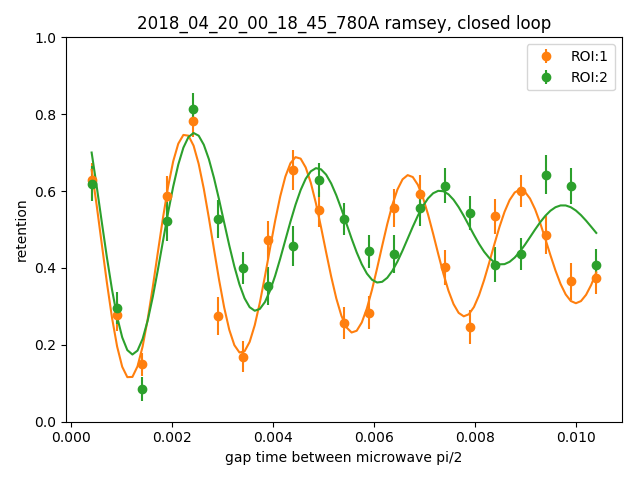

tau 1  is  0.0101025894656  with 1 std of   0.00248759262229
amplitude 1  is  0.37590726304  with 1 std of   0.0424969663323
frequency 1  is  452.417045862  with 1 std of   3.65256547384
phase 1  is  1.39316827135  with 1 std of   0.105541172269
offset 1  is  0.447908862744  with 1 std of   0.0109551891239
tau 2  is  0.0055481705562  with 1 std of   0.00155824773737
amplitude 2  is  0.398628209617  with 1 std of   0.0726649543088
frequency 2  is  410.228490137  with 1 std of   7.32619717935
phase 2  is  1.52255397018  with 1 std of   0.160427958263
offset 2  is  0.494552909778  with 1 std of   0.0150689822926
2018_04_20_00_44_51_780A ramsey, closed loop
27


<IPython.core.display.Javascript object>


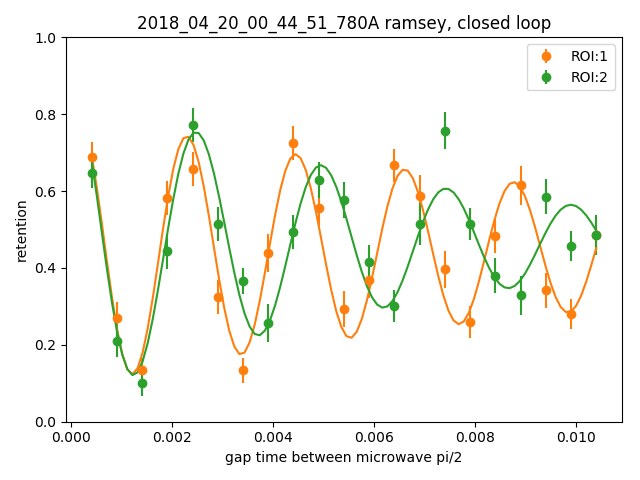

tau 1  is  0.0125645185124  with 1 std of   0.00356431088796
amplitude 1  is  0.355475233206  with 1 std of   0.0388561796851
frequency 1  is  463.177722328  with 1 std of   3.42353600536
phase 1  is  1.18239273923  with 1 std of   0.107430532246
offset 1  is  0.446568480168  with 1 std of   0.0108054526481
tau 2  is  0.00694745661257  with 1 std of   0.00191789304164
amplitude 2  is  0.411879397856  with 1 std of   0.0662059637534
frequency 2  is  403.792305888  with 1 std of   5.80105315838
phase 2  is  1.54237484052  with 1 std of   0.143188260719
offset 2  is  0.465529294227  with 1 std of   0.0150004098773
2018_04_20_08_32_02_780A ramsey, closed loop
28


<IPython.core.display.Javascript object>


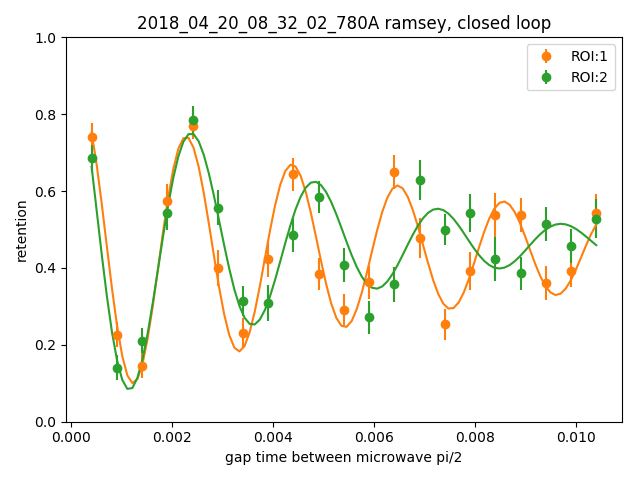

tau 1  is  0.00757939312479  with 1 std of   0.00117307586366
amplitude 1  is  0.403348702426  with 1 std of   0.033830328492
frequency 1  is  477.029799525  with 1 std of   3.36561241214
phase 1  is  1.00241660233  with 1 std of   0.0886490326571
offset 1  is  0.442877536328  with 1 std of   0.00862159681342
tau 2  is  0.00419385323899  with 1 std of   0.000843025973793
amplitude 2  is  0.504413620815  with 1 std of   0.0740473340034
frequency 2  is  409.304359389  with 1 std of   6.74441565331
phase 2  is  1.66702820794  with 1 std of   0.119559689373
offset 2  is  0.465184682225  with 1 std of   0.0130857993639
2018_04_20_09_20_41_780A ramsey, closed loop
29


<IPython.core.display.Javascript object>


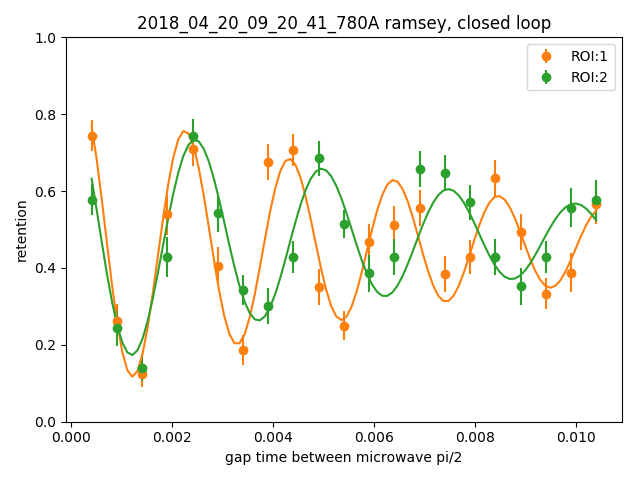

tau 1  is  0.00735040830427  with 1 std of   0.00190651449343
amplitude 1  is  0.40433944817  with 1 std of   0.0583231699662
frequency 1  is  483.160990056  with 1 std of   5.97995939175
phase 1  is  0.992146583717  with 1 std of   0.154087900618
offset 1  is  0.459648858071  with 1 std of   0.0147835741132
tau 2  is  0.0071934091791  with 1 std of   0.00229650020782
amplitude 2  is  0.360128834211  with 1 std of   0.0663807242156
frequency 2  is  398.446184956  with 1 std of   6.4495620987
phase 2  is  1.66986190266  with 1 std of   0.159616685752
offset 2  is  0.477905459383  with 1 std of   0.0150515737065
2018_04_20_10_49_28_780A ramsey, closed loop
30


<IPython.core.display.Javascript object>


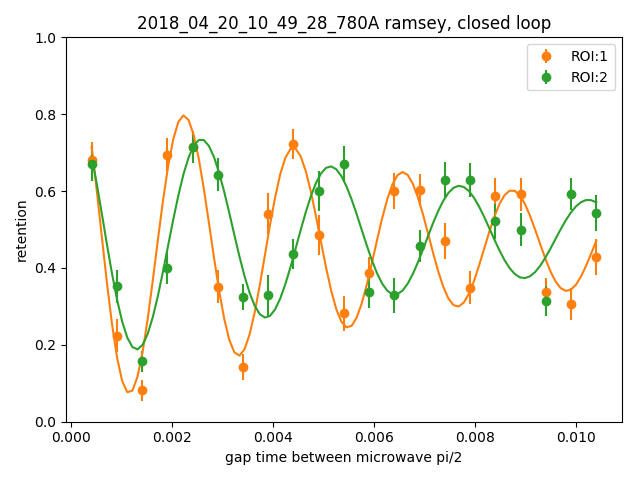

tau 1  is  0.00748560704973  with 1 std of   0.00161472979617
amplitude 1  is  0.451838085691  with 1 std of   0.0537845904366
frequency 1  is  461.314767524  with 1 std of   4.28734419323
phase 1  is  1.34995222375  with 1 std of   0.111053536012
offset 1  is  0.461807234064  with 1 std of   0.0127945866444
tau 2  is  0.0077716737899  with 1 std of   0.00236448508548
amplitude 2  is  0.349912828332  with 1 std of   0.0591786879017
frequency 2  is  391.013997596  with 1 std of   6.21623875776
phase 2  is  1.48361880271  with 1 std of   0.15902608123
offset 2  is  0.483726437573  with 1 std of   0.0143180479193
2018_04_20_11_47_15_780A ramsey, closed loop
31


<IPython.core.display.Javascript object>


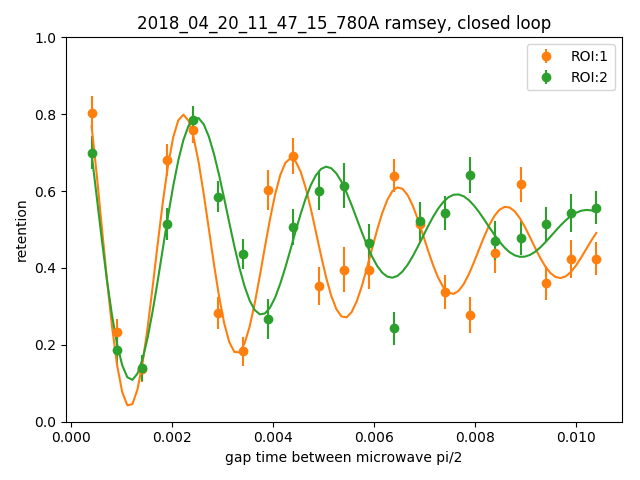

tau 1  is  0.00530057782968  with 1 std of   0.00122061820794
amplitude 1  is  0.519955207134  with 1 std of   0.0782959985862
frequency 1  is  468.798823747  with 1 std of   6.69847283827
phase 1  is  1.26261188122  with 1 std of   0.144315239997
offset 1  is  0.457216117297  with 1 std of   0.0166710711017
tau 2  is  0.00449776108231  with 1 std of   0.000798360109693
amplitude 2  is  0.510121165416  with 1 std of   0.0655735007761
frequency 2  is  387.694140975  with 1 std of   5.77030015497
phase 2  is  1.73050116293  with 1 std of   0.106005601125
offset 2  is  0.498552423789  with 1 std of   0.0121209976341
2018_04_20_12_26_31_780A ramsey, closed loop
32


<IPython.core.display.Javascript object>


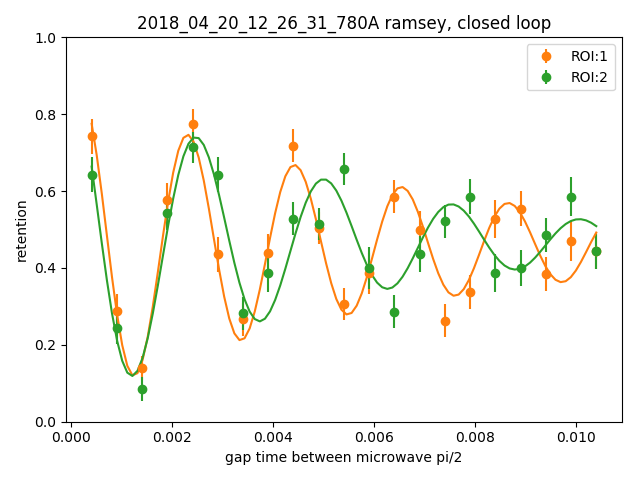

tau 1  is  0.00666547889687  with 1 std of   0.0011444093843
amplitude 1  is  0.408454210802  with 1 std of   0.0403009321534
frequency 1  is  471.955510024  with 1 std of   4.17937937566
phase 1  is  0.986262788243  with 1 std of   0.104710857893
offset 1  is  0.457942098652  with 1 std of   0.00986704613827
tau 2  is  0.00488274408285  with 1 std of   0.00119624101232
amplitude 2  is  0.449957378064  with 1 std of   0.076885547248
frequency 2  is  394.774012586  with 1 std of   7.34777266443
phase 2  is  1.66305254814  with 1 std of   0.144457237003
offset 2  is  0.46990202333  with 1 std of   0.0148837081202
2018_04_20_13_07_25_780A ramsey, closed loop
33


<IPython.core.display.Javascript object>


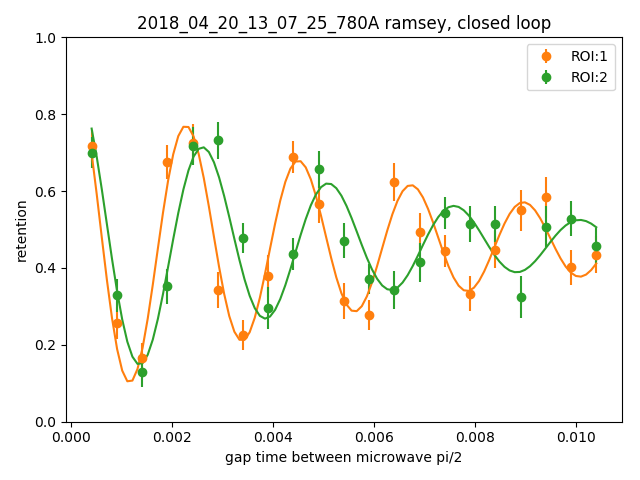

tau 1  is  0.00631263825964  with 1 std of   0.00126063960354
amplitude 1  is  0.436613180136  with 1 std of   0.0534303253888
frequency 1  is  448.473166352  with 1 std of   4.80234038523
phase 1  is  1.41207206779  with 1 std of   0.112646931353
offset 1  is  0.465637510112  with 1 std of   0.0118944923459
tau 2  is  0.0052528311242  with 1 std of   0.00120550835138
amplitude 2  is  0.409995636226  with 1 std of   0.0616342351708
frequency 2  is  401.447884731  with 1 std of   7.09279037991
phase 2  is  1.23237997043  with 1 std of   0.15278013721
offset 2  is  0.464941028774  with 1 std of   0.0133840491318
2018_04_20_13_49_08_780A ramsey, closed loop
34


<IPython.core.display.Javascript object>


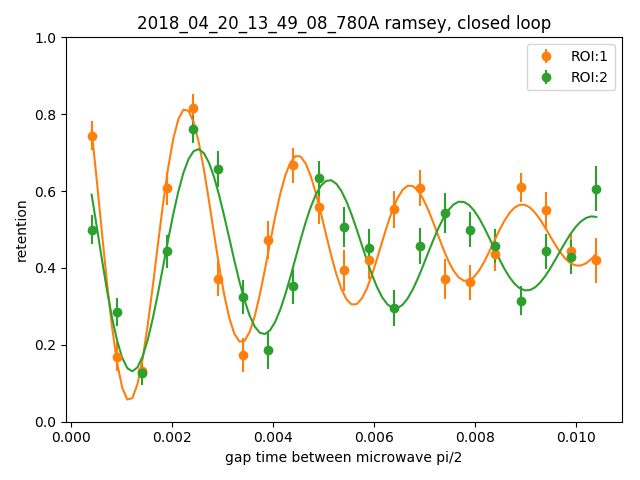

tau 1  is  0.00499283607339  with 1 std of   0.000641681034419
amplitude 1  is  0.531689038052  with 1 std of   0.0463469996993
frequency 1  is  449.550378471  with 1 std of   3.890105814
phase 1  is  1.40341330566  with 1 std of   0.0794439211323
offset 1  is  0.476639178427  with 1 std of   0.0093526819658
tau 2  is  0.00712517372565  with 1 std of   0.00193466798327
amplitude 2  is  0.374066399189  with 1 std of   0.0601060816524
frequency 2  is  383.663764647  with 1 std of   5.77008045375
phase 2  is  1.75763115674  with 1 std of   0.139264592329
offset 2  is  0.446584418067  with 1 std of   0.0136788123118
2018_04_20_14_27_42_780A ramsey, closed loop
35


<IPython.core.display.Javascript object>


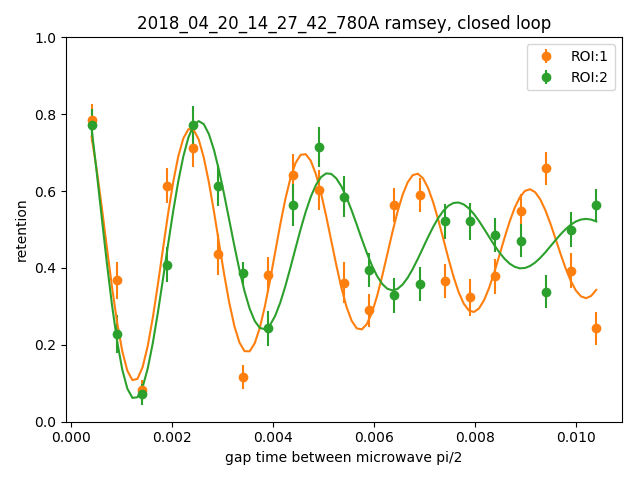

tau 1  is  0.0093095923621  with 1 std of   0.00281567976803
amplitude 1  is  0.398619885281  with 1 std of   0.0586884576019
frequency 1  is  447.130735445  with 1 std of   5.3082607294
phase 1  is  1.17279808148  with 1 std of   0.148914274959
offset 1  is  0.454628532462  with 1 std of   0.0154058556477
tau 2  is  0.00444508875107  with 1 std of   0.000807158296219
amplitude 2  is  0.549443186185  with 1 std of   0.0716266904941
frequency 2  is  391.355498426  with 1 std of   6.20784420946
phase 2  is  1.54272116918  with 1 std of   0.115480465741
offset 2  is  0.47246645647  with 1 std of   0.0135505180099
2018_04_20_14_51_43_780A ramsey, closed loop
36


<IPython.core.display.Javascript object>


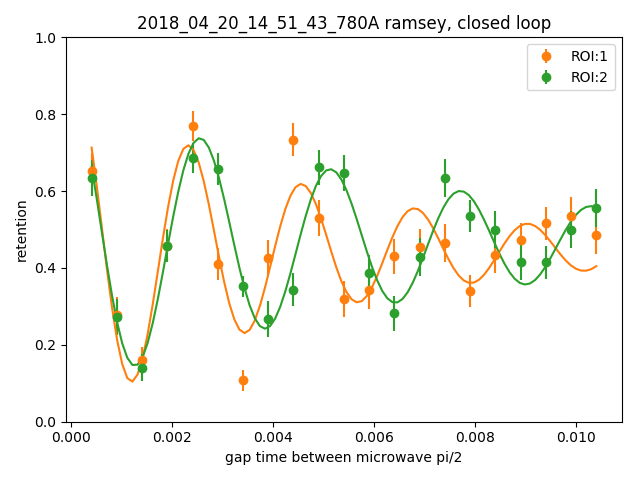

tau 1  is  0.00486569697741  with 1 std of   0.00135827988208
amplitude 1  is  0.439135014299  with 1 std of   0.08356907338
frequency 1  is  446.170500069  with 1 std of   8.99390034019
phase 1  is  1.30210393537  with 1 std of   0.181880428155
offset 1  is  0.446898491356  with 1 std of   0.01704285406
tau 2  is  0.00725815904431  with 1 std of   0.00126246836881
amplitude 2  is  0.383844344574  with 1 std of   0.0388546348378
frequency 2  is  387.490553392  with 1 std of   3.72033949887
phase 2  is  1.6028275565  with 1 std of   0.0914892322231
offset 2  is  0.467943616626  with 1 std of   0.00904966640774
2018_04_20_15_21_04_780A ramsey, closed loop
37


<IPython.core.display.Javascript object>


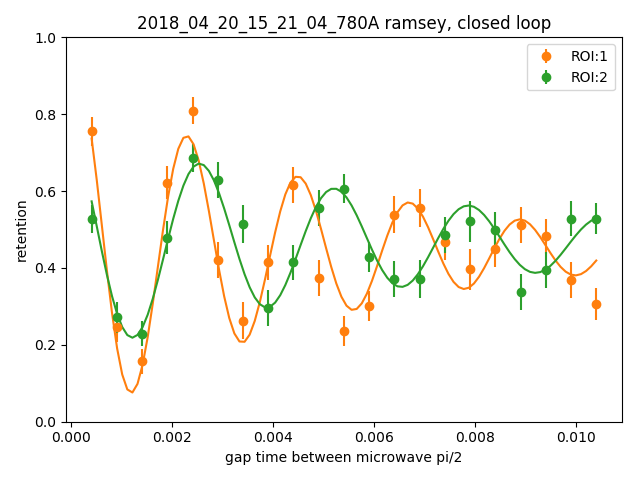

tau 1  is  0.00505753681342  with 1 std of   0.00111119989648
amplitude 1  is  0.469381245228  with 1 std of   0.0686050841142
frequency 1  is  454.475227489  with 1 std of   6.72028073177
phase 1  is  1.26412292641  with 1 std of   0.14069587741
offset 1  is  0.445683231683  with 1 std of   0.0142927786899
tau 2  is  0.007007438962  with 1 std of   0.00173290503592
amplitude 2  is  0.295146660196  with 1 std of   0.0434303548431
frequency 2  is  375.588676451  with 1 std of   5.23222120398
phase 2  is  1.8049406015  with 1 std of   0.125700286833
offset 2  is  0.46658655677  with 1 std of   0.00977256172762
2018_04_20_15_44_45_780A ramsey, closed loop
38


<IPython.core.display.Javascript object>


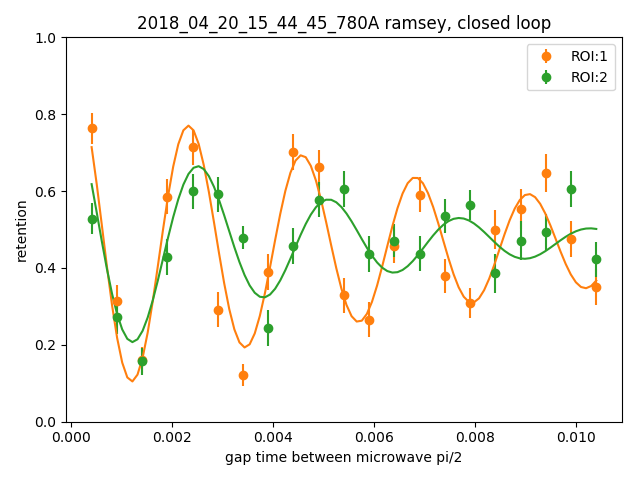

tau 1  is  0.00787649966504  with 1 std of   0.00239364139927
amplitude 1  is  0.415418026273  with 1 std of   0.0687667658023
frequency 1  is  445.0048281  with 1 std of   6.10234451836
phase 1  is  1.32696298783  with 1 std of   0.159103438335
offset 1  is  0.461118263117  with 1 std of   0.016804019772
tau 2  is  0.00442855221032  with 1 std of   0.0014817745531
amplitude 2  is  0.346060622921  with 1 std of   0.0841049452838
frequency 2  is  386.273797001  with 1 std of   11.1744958446
phase 2  is  1.68075350195  with 1 std of   0.20397251745
offset 2  is  0.469241891255  with 1 std of   0.0155466642473
2018_04_20_16_05_33_780A ramsey, closed loop
39


<IPython.core.display.Javascript object>


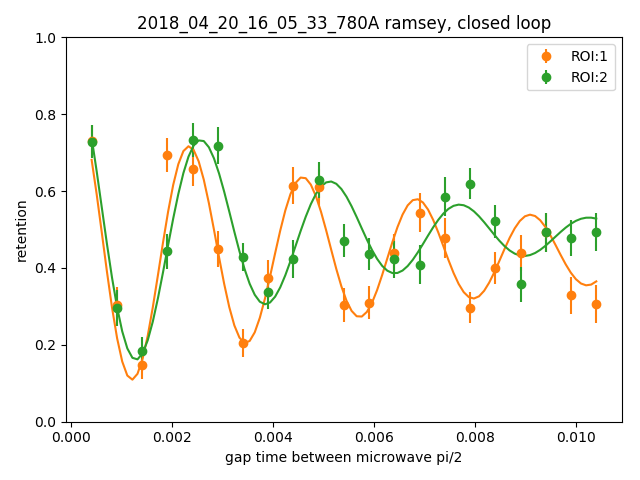

tau 1  is  0.00660864681404  with 1 std of   0.00162500916799
amplitude 1  is  0.395656229817  with 1 std of   0.0583775689917
frequency 1  is  443.450072011  with 1 std of   5.90222943284
phase 1  is  1.31840092885  with 1 std of   0.14187994207
offset 1  is  0.43886511427  with 1 std of   0.013484546906
tau 2  is  0.00441069391475  with 1 std of   0.000844011923949
amplitude 2  is  0.438909456302  with 1 std of   0.0602245633556
frequency 2  is  390.01673936  with 1 std of   6.71140546693
phase 2  is  1.48704306751  with 1 std of   0.124951936765
offset 2  is  0.488381688589  with 1 std of   0.0114958535189
2018_04_20_16_23_49_780A ramsey, closed loop
40


<IPython.core.display.Javascript object>


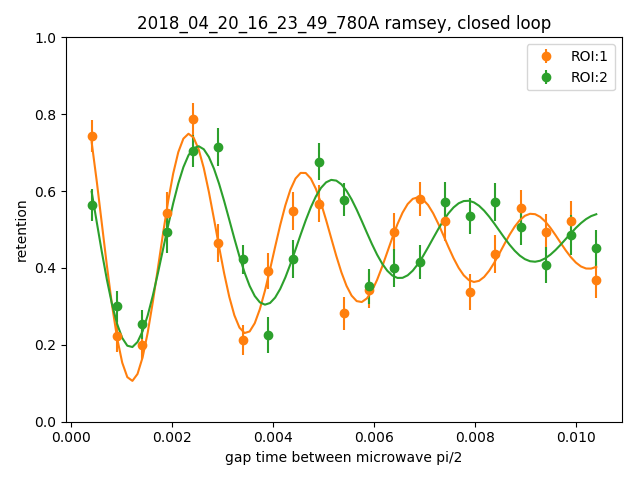

tau 1  is  0.00528385182862  with 1 std of   0.000855012946004
amplitude 1  is  0.447131707395  with 1 std of   0.048110911667
frequency 1  is  441.47430943  with 1 std of   4.82009871349
phase 1  is  1.33663855547  with 1 std of   0.102124504511
offset 1  is  0.46190265681  with 1 std of   0.010139139881
tau 2  is  0.00559141304134  with 1 std of   0.00158361641817
amplitude 2  is  0.362296703399  with 1 std of   0.0684630999345
frequency 2  is  375.328616771  with 1 std of   7.37087455224
phase 2  is  1.8590498791  with 1 std of   0.155675393047
offset 2  is  0.486233463169  with 1 std of   0.0139603515959
2018_04_20_16_40_40_780A ramsey, closed loop
41


<IPython.core.display.Javascript object>


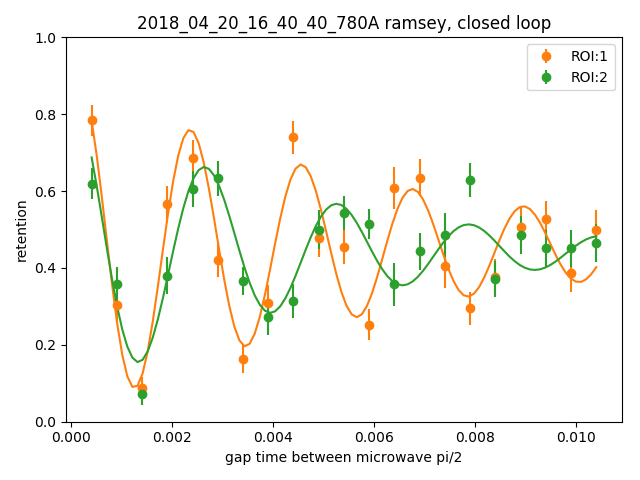

tau 1  is  0.00629255827655  with 1 std of   0.00160700765054
amplitude 1  is  0.445989452306  with 1 std of   0.0681303103774
frequency 1  is  454.203115488  with 1 std of   6.55795457696
phase 1  is  1.09291418691  with 1 std of   0.157779569706
offset 1  is  0.453265024246  with 1 std of   0.0160350566317
tau 2  is  0.00450027364451  with 1 std of   0.00114587140588
amplitude 2  is  0.391713773712  with 1 std of   0.0705938874324
frequency 2  is  381.936794849  with 1 std of   8.86087190519
phase 2  is  1.44075963337  with 1 std of   0.168843896956
offset 2  is  0.445589308327  with 1 std of   0.013817612849
2018_04_20_17_23_53_780A ramsey, closed loop
42


<IPython.core.display.Javascript object>


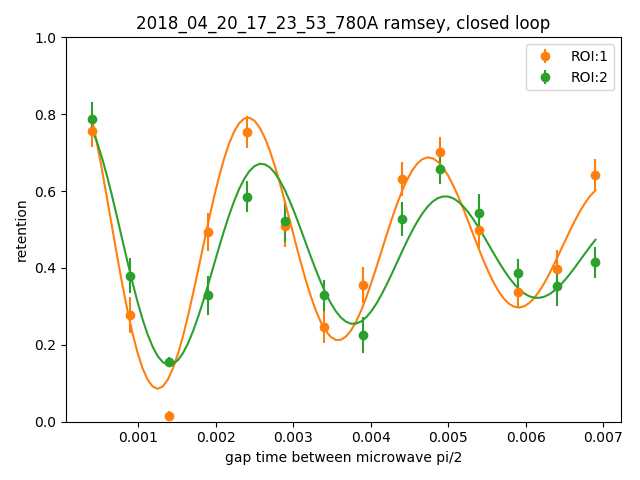

tau 1  is  0.00590839055029  with 1 std of   0.00149557823656
amplitude 1  is  0.479814414004  with 1 std of   0.0628359471285
frequency 1  is  429.46221278  with 1 std of   7.07063825669
phase 1  is  1.27248636639  with 1 std of   0.131639549857
offset 1  is  0.473155667729  with 1 std of   0.0159267540258
tau 2  is  0.00521482510454  with 1 std of   0.00164884216112
amplitude 2  is  0.382389279515  with 1 std of   0.0633143774973
frequency 2  is  421.274285561  with 1 std of   10.2379145358
phase 2  is  0.928773162227  with 1 std of   0.19243363245
offset 2  is  0.439233502146  with 1 std of   0.0166778161198
2018_04_20_18_10_59_780A ramsey, closed loop
43


<IPython.core.display.Javascript object>


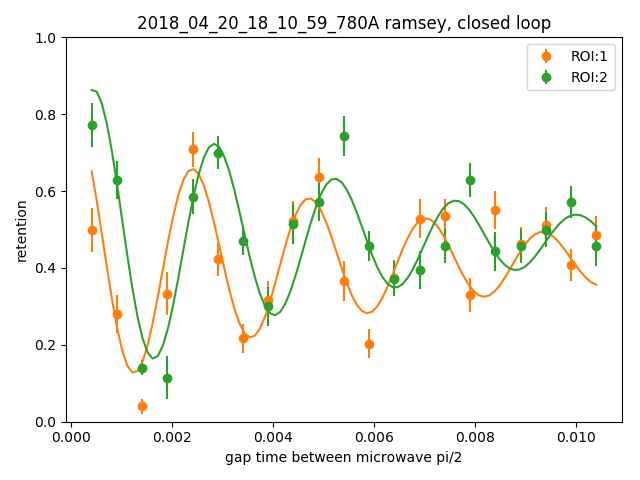

tau 1  is  0.00605406066451  with 1 std of   0.00245233950513
amplitude 1  is  0.357435365564  with 1 std of   0.0903404155278
frequency 1  is  432.384461282  with 1 std of   10.6656522326
phase 1  is  1.28184343636  with 1 std of   0.246525153653
offset 1  is  0.417503915477  with 1 std of   0.0203815532641
tau 2  is  0.00529436683785  with 1 std of   0.00143523568759
amplitude 2  is  0.424124920206  with 1 std of   0.0707253096553
frequency 2  is  418.107553646  with 1 std of   9.20315995611
phase 2  is  0.35658823892  with 1 std of   0.208159662005
offset 2  is  0.474858219166  with 1 std of   0.0172941176513
2018_04_20_19_40_13_780A ramsey, closed loop
44


<IPython.core.display.Javascript object>


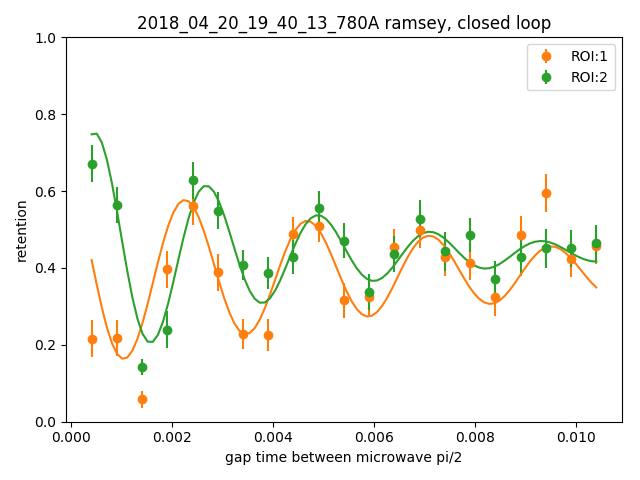

tau 1  is  0.0071516358741  with 1 std of   0.0047673478676
amplitude 1  is  0.259712754421  with 1 std of   0.100802767064
frequency 1  is  413.005760553  with 1 std of   13.0139707878
phase 1  is  1.96893147145  with 1 std of   0.318913549518
offset 1  is  0.387654155045  with 1 std of   0.0222819716622
tau 2  is  0.00381521639432  with 1 std of   0.000870532212732
amplitude 2  is  0.353744196222  with 1 std of   0.0544458802355
frequency 2  is  451.892014872  with 1 std of   10.9210278033
phase 2  is  0.179896801973  with 1 std of   0.197865839902
offset 2  is  0.439435050467  with 1 std of   0.0115858330891
2018_04_20_20_20_52_780A ramsey, closed loop
45


<IPython.core.display.Javascript object>


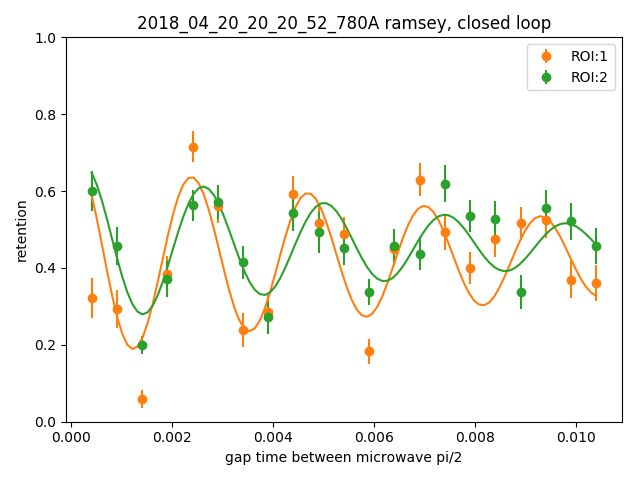

tau 1  is  0.0105487325655  with 1 std of   0.00787618230405
amplitude 1  is  0.265264267747  with 1 std of   0.0900895658829
frequency 1  is  433.139979384  with 1 std of   11.3627686484
phase 1  is  1.35390249955  with 1 std of   0.327884576374
offset 1  is  0.425116769273  with 1 std of   0.02387323048
tau 2  is  0.00731826273965  with 1 std of   0.00379416470049
amplitude 2  is  0.218535425577  with 1 std of   0.0613194450793
frequency 2  is  417.90916685  with 1 std of   11.5171035146
phase 2  is  0.942692420227  with 1 std of   0.305422053559
offset 2  is  0.459119501617  with 1 std of   0.0156102883704
2018_04_21_14_01_47_780A ramsey, closed loop
46


<IPython.core.display.Javascript object>


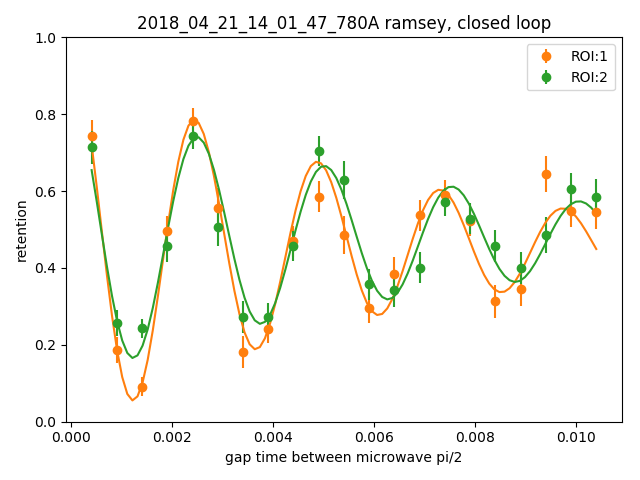

tau 1  is  0.00604800868719  with 1 std of   0.0011476073689
amplitude 1  is  0.492363134495  with 1 std of   0.0581399838239
frequency 1  is  411.058919772  with 1 std of   4.55159946804
phase 1  is  1.49946703261  with 1 std of   0.105179338123
offset 1  is  0.45689162385  with 1 std of   0.0125362660989
tau 2  is  0.00751339390321  with 1 std of   0.00178158809144
amplitude 2  is  0.367442716701  with 1 std of   0.0492039480445
frequency 2  is  396.230476108  with 1 std of   4.71953803314
phase 2  is  1.61223119517  with 1 std of   0.118991414143
offset 2  is  0.477363352179  with 1 std of   0.011451804096
2018_04_21_14_39_59_780A ramsey, closed loop
47


<IPython.core.display.Javascript object>


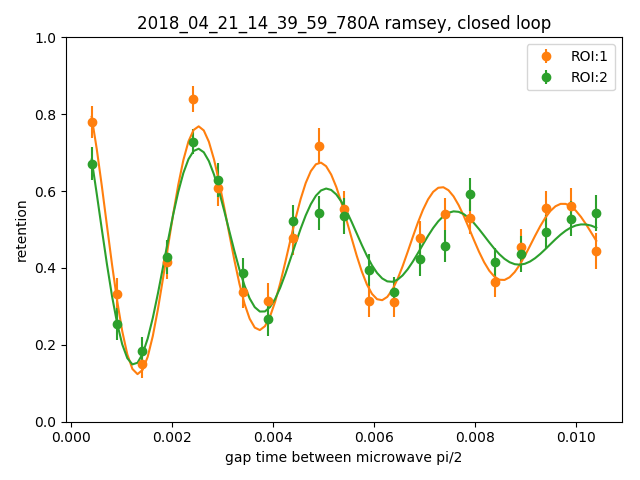

tau 1  is  0.00615522744652  with 1 std of   0.00097053343224
amplitude 1  is  0.43879444435  with 1 std of   0.0418294543112
frequency 1  is  415.253268064  with 1 std of   3.9532754192
phase 1  is  1.22279328281  with 1 std of   0.0944874880685
offset 1  is  0.477544781178  with 1 std of   0.00955115767452
tau 2  is  0.00455122984897  with 1 std of   0.000779702597114
amplitude 2  is  0.421593635256  with 1 std of   0.0514869674346
frequency 2  is  393.100715793  with 1 std of   5.66506752008
phase 2  is  1.56720520158  with 1 std of   0.10692921437
offset 2  is  0.468305904607  with 1 std of   0.00979627025136
2018_04_21_15_14_06_780A ramsey, closed loop
48


<IPython.core.display.Javascript object>


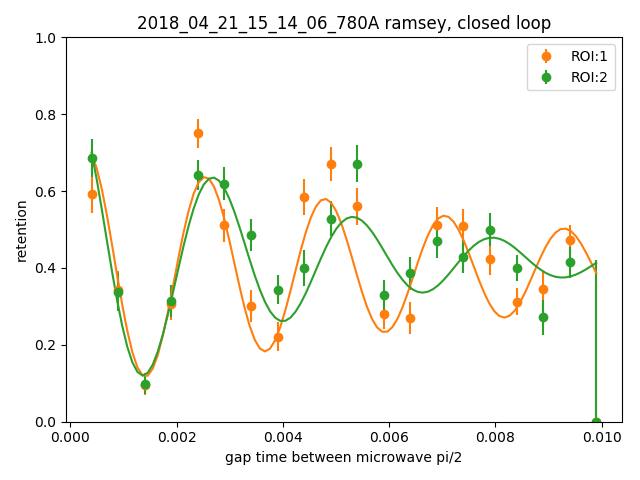

tau 1  is  0.00837664167986  with 1 std of   0.00588778002086
amplitude 1  is  0.328325513703  with 1 std of   0.111038109583
frequency 1  is  444.061413208  with 1 std of   13.8687385494
phase 1  is  0.732316443967  with 1 std of   0.381581123631
offset 1  is  0.394633022043  with 1 std of   0.030374929404
tau 2  is  0.00410862812188  with 1 std of   0.00219156905665
amplitude 2  is  0.418276624435  with 1 std of   0.157616299202
frequency 2  is  380.053589173  with 1 std of   20.2354824561
phase 2  is  1.35058866418  with 1 std of   0.365220763811
offset 2  is  0.418718214114  with 1 std of   0.0303866416384
2018_04_21_15_47_33_780A ramsey, closed loop
49


<IPython.core.display.Javascript object>


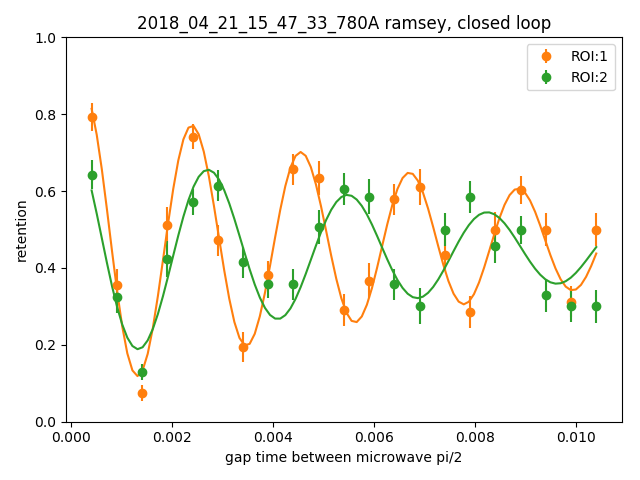

tau 1  is  0.00837745058846  with 1 std of   0.00117670759842
amplitude 1  is  0.406137057071  with 1 std of   0.0285237106752
frequency 1  is  463.944254383  with 1 std of   2.73821237893
phase 1  is  0.857000656482  with 1 std of   0.0765593658349
offset 1  is  0.465761860453  with 1 std of   0.00759714729238
tau 2  is  0.00751170527677  with 1 std of   0.00301162008279
amplitude 2  is  0.30445495707  with 1 std of   0.0680932669735
frequency 2  is  361.50443636  with 1 std of   7.66151707052
phase 2  is  1.65327254646  with 1 std of   0.196193363413
offset 2  is  0.443508854692  with 1 std of   0.0157659268708
2018_04_21_18_53_41_780A ramsey, closed loop
50


<IPython.core.display.Javascript object>


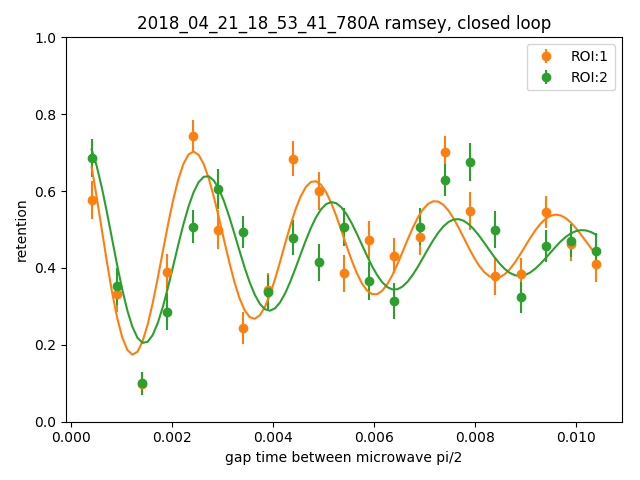

tau 1  is  0.0061753594483  with 1 std of   0.00260774623196
amplitude 1  is  0.353894361495  with 1 std of   0.0920754101374
frequency 1  is  417.539631389  with 1 std of   10.0695825919
phase 1  is  1.45231109144  with 1 std of   0.235776323447
offset 1  is  0.464206947686  with 1 std of   0.020184593285
tau 2  is  0.00574993962332  with 1 std of   0.00249355057869
amplitude 2  is  0.310372304936  with 1 std of   0.0832461832623
frequency 2  is  403.295326363  with 1 std of   13.0412877475
phase 2  is  0.989941507493  with 1 std of   0.301152224849
offset 2  is  0.44528786582  with 1 std of   0.019772094364
2018_04_21_19_12_49_780A ramsey, closed loop
51


<IPython.core.display.Javascript object>


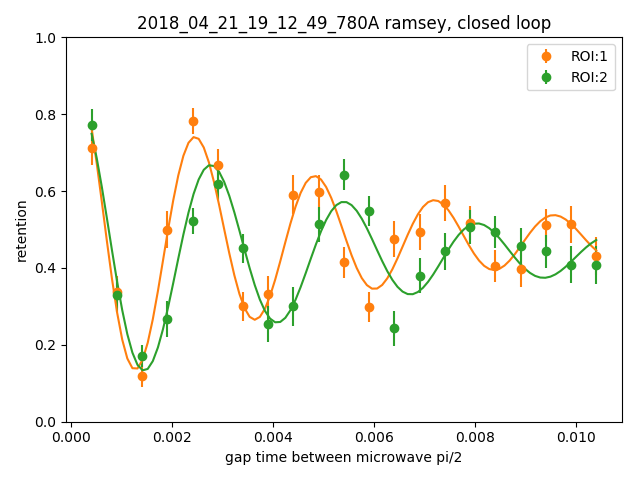

tau 1  is  0.00492787113601  with 1 std of   0.000941260412898
amplitude 1  is  0.439018126709  with 1 std of   0.0563477369596
frequency 1  is  421.809419038  with 1 std of   5.97666565614
phase 1  is  1.29254305321  with 1 std of   0.123629392045
offset 1  is  0.474680179255  with 1 std of   0.0116022943288
tau 2  is  0.00496789268105  with 1 std of   0.00102130630872
amplitude 2  is  0.406096011764  with 1 std of   0.0553139828642
frequency 2  is  378.915649088  with 1 std of   6.79802611939
phase 2  is  1.20019109128  with 1 std of   0.142973768551
offset 2  is  0.435815613215  with 1 std of   0.0120013792041
2018_04_21_19_33_26_780A ramsey, closed loop
52


<IPython.core.display.Javascript object>


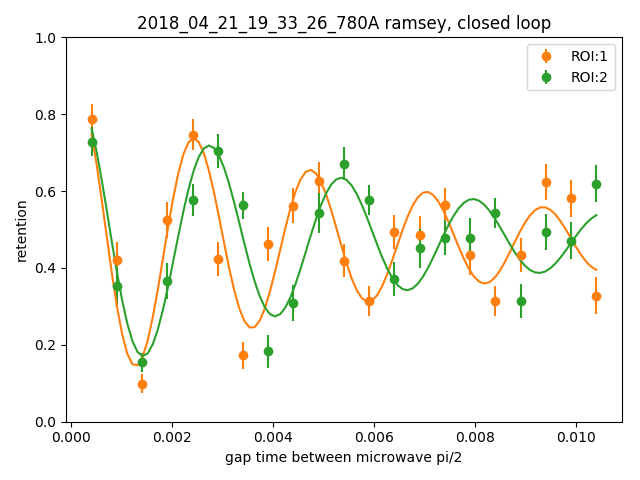

tau 1  is  0.00634773777094  with 1 std of   0.0020772501486
amplitude 1  is  0.395023192742  with 1 std of   0.0783659361437
frequency 1  is  433.544823668  with 1 std of   8.3771620241
phase 1  is  1.19775194621  with 1 std of   0.199903272203
offset 1  is  0.467997995241  with 1 std of   0.0182823381247
tau 2  is  0.00624328873748  with 1 std of   0.00178075908179
amplitude 2  is  0.380849311848  with 1 std of   0.0660744368987
frequency 2  is  382.529925084  with 1 std of   7.52900293701
phase 2  is  1.23249538725  with 1 std of   0.178889686495
offset 2  is  0.473177802786  with 1 std of   0.0155889582945
2018_04_21_19_55_13_780A ramsey, closed loop
53


<IPython.core.display.Javascript object>


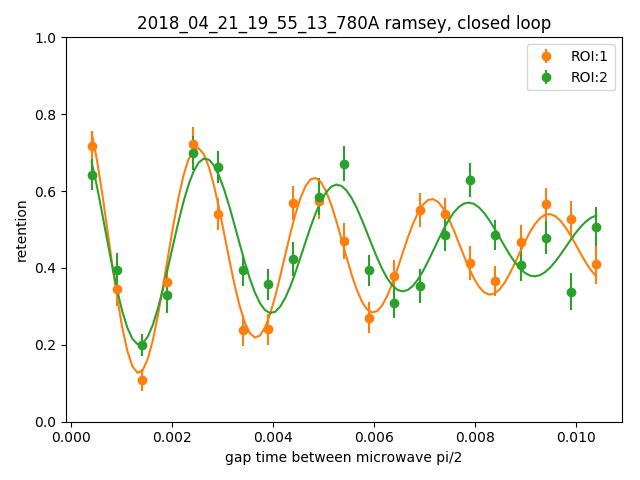

tau 1  is  0.00679043454445  with 1 std of   0.000956354387941
amplitude 1  is  0.387227708472  with 1 std of   0.0314082633544
frequency 1  is  430.553756445  with 1 std of   3.40855145472
phase 1  is  1.05644216913  with 1 std of   0.0855950964589
offset 1  is  0.444349867855  with 1 std of   0.00768453141084
tau 2  is  0.00704365890407  with 1 std of   0.00225170076279
amplitude 2  is  0.320860965354  with 1 std of   0.0598375727976
frequency 2  is  383.266308659  with 1 std of   7.28129301186
phase 2  is  1.41086534667  with 1 std of   0.179948853823
offset 2  is  0.46525733039  with 1 std of   0.0142468894205
2018_04_21_20_16_19_780A ramsey, closed loop
54


<IPython.core.display.Javascript object>


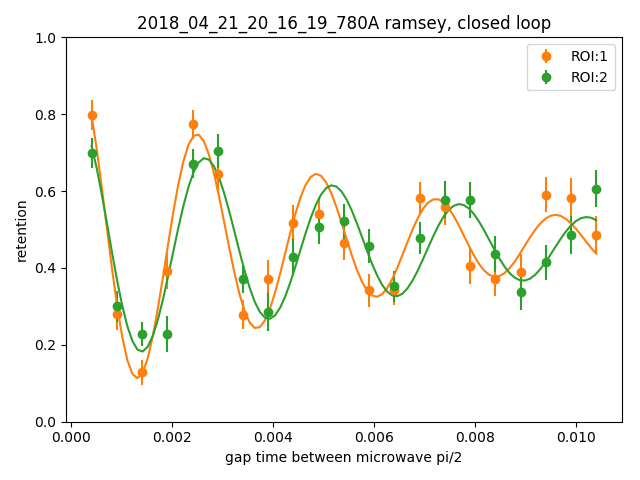

tau 1  is  0.00518088184263  with 1 std of   0.000957847345191
amplitude 1  is  0.455866981361  with 1 std of   0.0549411465745
frequency 1  is  422.293185895  with 1 std of   5.62735016624
phase 1  is  1.18598045897  with 1 std of   0.121593390601
offset 1  is  0.466739556558  with 1 std of   0.0118316444461
tau 2  is  0.00679292431795  with 1 std of   0.00196491519715
amplitude 2  is  0.338177754562  with 1 std of   0.0572831889427
frequency 2  is  396.757869499  with 1 std of   7.14495123241
phase 2  is  1.19419274842  with 1 std of   0.176192230614
offset 2  is  0.457354629852  with 1 std of   0.0139095394416
2018_04_21_20_36_32_780A ramsey, closed loop
55


<IPython.core.display.Javascript object>


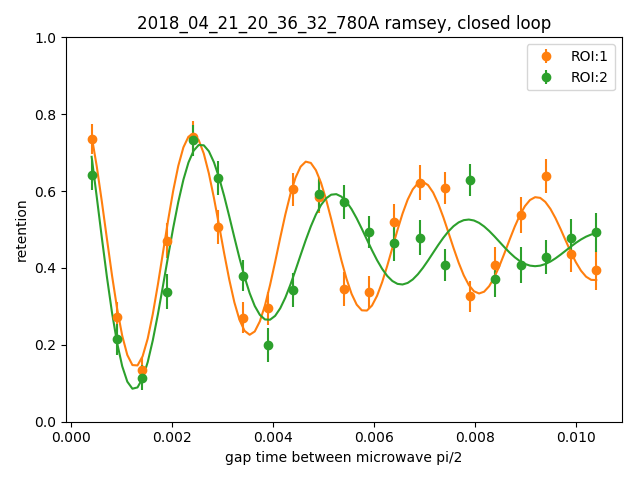

tau 1  is  0.00775263124611  with 1 std of   0.00141900263271
amplitude 1  is  0.382326824518  with 1 std of   0.0383265842398
frequency 1  is  439.897768771  with 1 std of   3.91018277871
phase 1  is  1.17705545664  with 1 std of   0.101941099392
offset 1  is  0.468258496377  with 1 std of   0.00959038641998
tau 2  is  0.00399500422295  with 1 std of   0.000859768697989
amplitude 2  is  0.508747039146  with 1 std of   0.0818330861954
frequency 2  is  377.575846755  with 1 std of   7.91824280496
phase 2  is  1.65968835335  with 1 std of   0.134639516648
offset 2  is  0.455330494398  with 1 std of   0.014339005483


In [104]:
save_figures=False
data11 = []
for n in range(0,len(assorted['exp_ids'])):    
    print assorted['exp_ids'][n]
    assorted_roi3freqs=[]
    assorted_roi2freqs=[]
    assorted_roi3perr=[]
    assorted_roi2perr=[]
    i = n
    print i
    exp_id=assorted['exp_ids'][i]
    q=assorted['qdp_class'][i]
    q.experiments[0]['variable_list']
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
    q.get_thresholds()
    retention = q.apply_thresholds()


    colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    fig, ax = plt.subplots()
    fit_guesses=[0.016, 0.35, 410 ,1.3, 0.45]
    fit_guesses2=[0.016, 0.3, 410 ,1.3, 0.45]
    #roi_dependency=[0,0,0,0,0]
    fitted_parameters=[]
    freqarray = []
    for roi in [1,2]:
        error=0
        data = []
        reten = []
        err = []

        for e in range(len(np.squeeze(retention['ivar']))):
            data.append(np.squeeze(retention['ivar'])[e][roi])
            reten.append(np.squeeze(retention['retention'])[e][roi])
            err.append(np.squeeze(retention['error'])[e][roi])
        ax.errorbar(data,reten,yerr=err,label="ROI:{}".format(roi),fmt='o',color=colors[roi])
        #guesses=np.add(fit_guesses,np.ones(len(fit_guesses))*(roi-2)*roi_dependency)
        #try:
       # decaying_sin(t,tau,amp,freq,phase,offset)
        try:
            fit,pcov = curve_fit(decaying_sin,data,reten,fit_guesses) #gaussian(x,amp,x0,sigma,offset):
            perr = np.sqrt(np.diag(pcov))
            print 'tau',roi," is ", fit[0]," with 1 std of  ", perr[0]
            print 'amplitude',roi," is ", fit[1]," with 1 std of  ", perr[1]
            print 'frequency',roi," is ", fit[2]," with 1 std of  ", perr[2]
            print 'phase', roi," is ", fit[3]," with 1 std of  ", perr[3]
            print 'offset',roi," is ", fit[4]," with 1 std of  ", perr[4]
            freqarray.append(fit[2])
            freqarray.append(perr[2])

        except:
            fit,pcov = curve_fit(decaying_sin,data,reten,fit_guesses2) #gaussian(x,amp,x0,sigma,offset):
            perr = np.sqrt(np.diag(pcov))
            print 'tau',roi," is ", fit[0]," with 1 std of  ", perr[0]
            print 'amplitude',roi," is ", fit[1]," with 1 std of  ", perr[1]
            print 'frequency',roi," is ", fit[2]," with 1 std of  ", perr[2]
            print 'phase', roi," is ", fit[3]," with 1 std of  ", perr[3]
            print 'offsett',roi," is ", fit[4]," with 1 std of  ", perr[4]
            freqarray.append(fit[2])
            freqarray.append(perr[2])

           #fit2,pcov2 = curve_fit(gaussian,data,reten,fit_guesses2) #gaussian(x,amp,x0,sigma,offset):
       # except RuntimeError:
       #     error=1
    #     if error is not 1:
    #         print "amplitude: {} , x0: {}, sigma:{} ".format(fit[0],fit[1],fit[2])
    #         print "amplitude: {} , x0: {}, sigma:{} ".format(fit2[0],fit2[1],fit2[2])

        xarray=np.linspace(np.min(data),np.max(data),100)
        yfit=decaying_sin(xarray, fit[0], fit[1], fit[2], fit[3],fit[4])
        plt.plot(xarray,yfit,color=colors[roi])
           # yfit2=gaussian(xarray, fit2[0], fit2[1], fit2[2], fit2[3])
            #plt.plot(xarray,yfit,label="mj=5/2", color=colors[0])
            #plt.plot(xarray,yfit2,label="mj=3/2", color=colors[1])

    #         if roi==3:
    #             assorted_roi3freqs.append(fit[2])
    #             assorted_roi3perr.append(np.sqrt(pcov[2][2]))
    #         elif roi==2:
    #             assorted_roi2freqs.append(fit[2])
    #             assorted_roi2perr.append(np.sqrt(pcov[2][2]))

    ax.set_title(exp_id)
    ax.set_ylim(0, 1)
    ax.set_xlabel(xlab)
    ax.set_ylabel('retention')
    ax.legend()
    plt.tight_layout()
    plt.show()
    if save_figures:
        plt.savefig('{}.pdf'.format(exp_id))
    
    
    
    starting_time = dt.datetime.fromtimestamp(int(assorted['timestamps'][i][0])).strftime('%Y-%m-%d %H:%M:%S')
    end_time = dt.datetime.fromtimestamp(int(assorted['timestamps'][i][len(assorted['timestamps'][i])-1])).strftime('%Y-%m-%d %H:%M:%S')
    middle_time = dt.datetime.fromtimestamp(int((assorted['timestamps'][i][0]+assorted['timestamps'][i][len(assorted['timestamps'][i])-1])/2 )).strftime('%H:%M')
    time_length = (assorted['timestamps'][i][len(assorted['timestamps'][i])-1])-assorted['timestamps'][i][0]
    time_from_data_start = ((assorted['timestamps'][i][0]+assorted['timestamps'][i][len(assorted['timestamps'][i])-1])/2 ) - assorted['timestamps'][0][0] 
    data11.append([ starting_time,end_time,freqarray[0],freqarray[1],freqarray[2],freqarray[3],middle_time,time_length,time_from_data_start])



In [105]:
off_data=[]
offtimestamps=[]
for i in range(0,len(assorted['exp_ids'])):
   # print 'Relative AC stark shift (r1/r2) = {:.3f} (and put uncertainty here)'.format(data11[i][2]/data11[i][4])
    if data11[i][2]/data11[i][4] > 2 or data11[i][2]/data11[i][4] < 0.5:
        off_data.append(data11[i][2]/data11[i][4])
        
        offtimestamps.append(dt.datetime.fromtimestamp(assorted['timestamps'][i][0]))
    else:
        off_data.append(np.nan)
        offtimestamps.append(dt.datetime.fromtimestamp(assorted['timestamps'][i][0]))

<IPython.core.display.Javascript object>


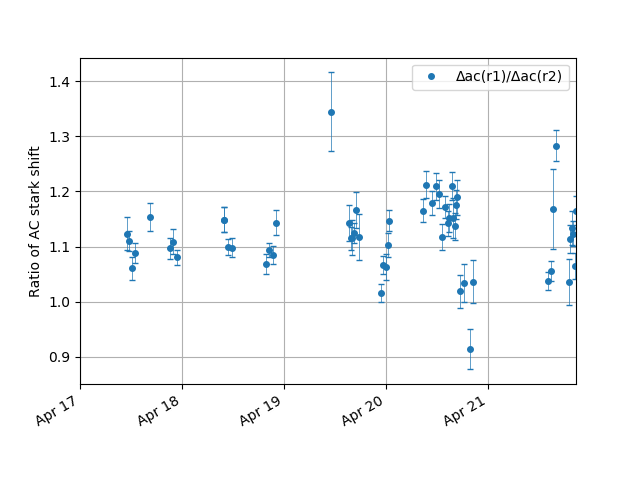

<IPython.core.display.Javascript object>


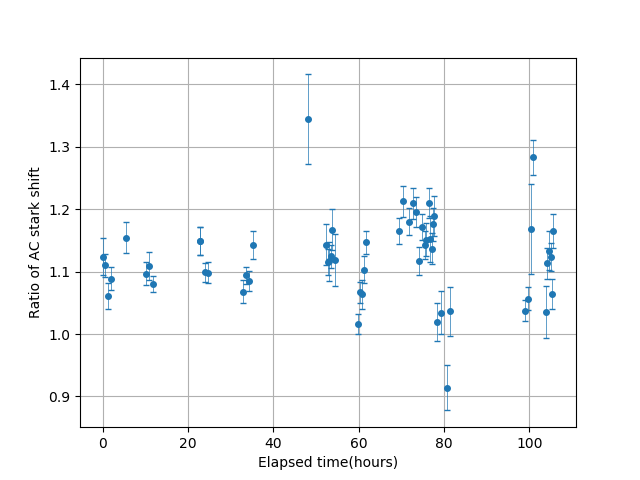

In [106]:

ratio_data=[]
ratio_error=[]
avetimestamp=[]
timelength=[]
startingtime=[]
startingtime_in_UNIX=[]

for i in range(0,len(assorted['exp_ids'])):
    startingtime.append(dt.datetime.fromtimestamp(assorted['timestamps'][i][0]))
    startingtime_in_UNIX.append(assorted['timestamps'][i][0])
    ratio_data.append(data11[i][2]/data11[i][4])
    error_total=np.sqrt(((1/data11[i][4])*data11[i][3])**2+(((data11[i][2]/(data11[i][4])**2)*data11[i][5])**2))
    ratio_error.append(error_total)
    avetimestamp.append(data11[i][6])

#samplerate='2S'
df=pd.DataFrame({  "Δac(r1)/Δac(r2)": ratio_data,'timestamps': avetimestamp,'error': ratio_error,'off_data': off_data},index=startingtime)

ax=df.plot(y=[ "Δac(r1)/Δac(r2)"],yerr='error',capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None',color=['#1f77b4', '#d62728'])
days=md.DayLocator()
hours=md.HourLocator()
ax.set_xlim(dt.datetime(2018,4,17))
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(md.DateFormatter('%b %d'))
ax.set_ylabel('Ratio of AC stark shift')
ax.grid()
#plt.savefig('Alignment_20180415.png')

timediff=(startingtime_in_UNIX-startingtime_in_UNIX[0])/(3600)
fig, ax = plt.subplots()
ax.errorbar(timediff,ratio_data,yerr=ratio_error,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
ax.set_xlabel('Elapsed time(hours)')
ax.set_ylabel('Ratio of AC stark shift')
ax.grid()

<QDP.qdp.QDP instance at 0x000000002BB4FA88>
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
<QDP.qdp.QDP instance at 0x000000001F219A08>
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
<QDP.qdp.QDP instance at 0x0000000032127E88>
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
<QDP.qdp.QDP instance at 0x0000000011472BC8>
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2173.0
-2172.85834059
-2172.74834415
-2172.54620512
-2172.56497465
-2172.56379755
-2172.36750366
-2172.0141172
-2171.93221258
-2172.06100614
-2172.01015538
-2172.0031551
-2172.00040469
-2171.90438961
<QDP.qdp.QDP instance at 0x000000001B0B7448>
-2173.23421512

<IPython.core.display.Javascript object>


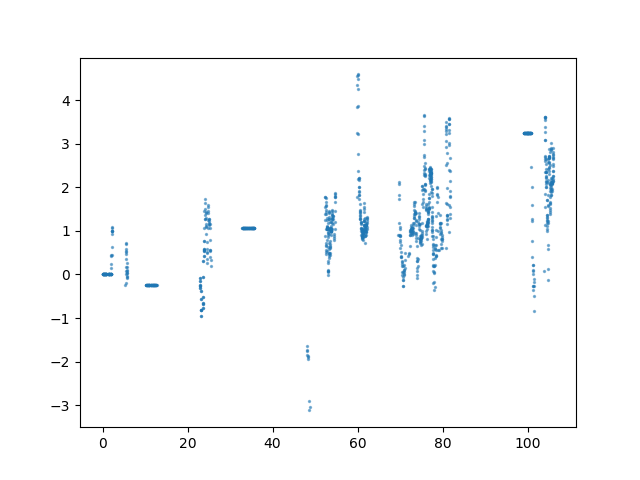

In [186]:
actuator_x=[]

assorted['qdp_class'][0].experiments[0]['iterations']
for q in assorted['qdp_class']:
    print q
    for iter in q.experiments[0]['iterations']:
        value=q.experiments[0]['iterations'][iter]['variables']['Corrected_Red_X']
        actuator_x.append(value)
        print value


elapsed_time_in_hours=np.array(data['timestamp_iteration'])/3600.0-np.array(data['timestamp_iteration'][0])/3600.0
        
fig, ax = plt.subplots()
plt.scatter(elapsed_time_in_hours,actuator_x-actuator_x[0],alpha=0.5,s=2)
#plt.plot(elapsed_time_in_hours,actuator_x-actuator_x[0])
# plt.show()


<IPython.core.display.Javascript object>


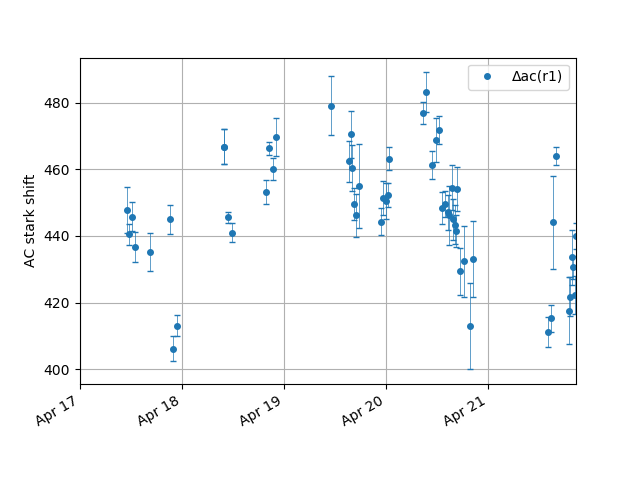

<IPython.core.display.Javascript object>


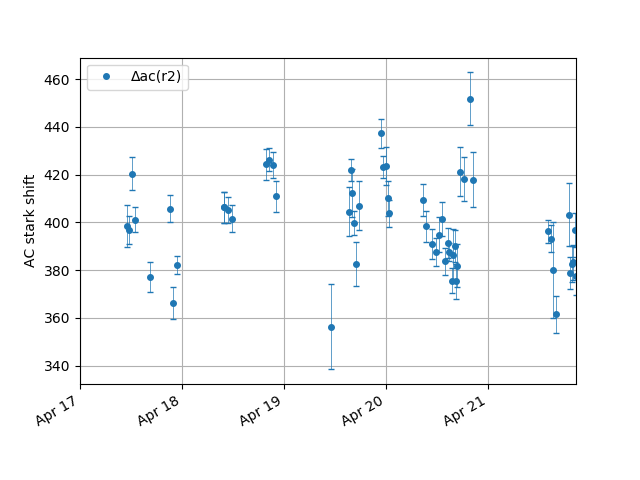

In [108]:

ROI1_ac=[]
ROI1_err=[]
ROI2_ac=[]
ROI2_err=[]
avetimestamp=[]
timelength=[]
startingtime=[]
ROI_err=[]

for i in range(0,len(assorted['exp_ids'])):
    startingtime.append(dt.datetime.fromtimestamp(assorted['timestamps'][i][0]))
    ROI1_ac.append(data11[i][2])
    ROI_err.append([data11[i][3],data11[i][5]])
   # ROI_err.append(data11[i][3])
   # ROI_err.append(data11[i][5])
    ROI1_err.append(data11[i][3])
    ROI2_ac.append(data11[i][4])
    ROI2_err.append(data11[i][5])
    #ratio_error.append(error_total)
    avetimestamp.append(data11[i][6])
 
# Using Pandas

df2=pd.DataFrame({  "Δac(r1)": ROI1_ac,'Δac(r2)':ROI2_ac,'timestamps': avetimestamp,'ROI_err': ROI_err},index=startingtime)

ax=df2.plot(y=[ "Δac(r1)"],yerr=ROI1_err,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
hours=md.HourLocator()
ax.set_xlim(dt.datetime(2018,4,17))
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(md.DateFormatter('%b %d'))
ax.set_ylabel('AC stark shift')
ax.grid()

ax2=df2.plot(y=[ "Δac(r2)"],yerr=ROI2_err,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
hours=md.HourLocator()
ax2.set_xlim(dt.datetime(2018,4,17))
ax2.xaxis.set_major_locator(days)
ax2.xaxis.set_major_formatter(md.DateFormatter('%b %d'))
ax2.set_ylabel('AC stark shift')
ax2.grid()


<IPython.core.display.Javascript object>


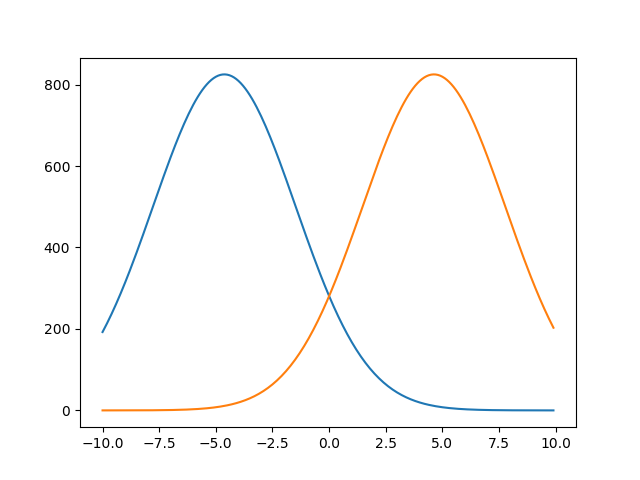

<IPython.core.display.Javascript object>


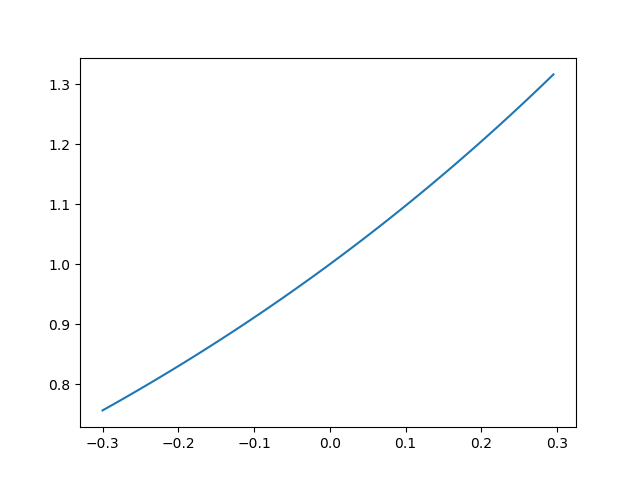

In [114]:
peakshift = 825
wx = 6.3
spacing = 9.25
xx = np.arange(-10.0, 10.0, 0.1)
#rint xx
fig, ax = plt.subplots()
plt.plot(xx,gaussian(xx,peakshift,-spacing/2,wx,0))
plt.plot(xx,gaussian(xx,peakshift,spacing/2,wx,0))
plt.show()

fig, ax = plt.subplots()
xxx = np.arange(-.3, 0.3, 0.005)
plt.plot(xxx,(gaussian(xxx,peakshift,spacing/2,wx,0)/gaussian(xxx,peakshift,-spacing/2,wx,0)))
plt.show()


In [115]:
def gaussian2(x,amp,x0,sigma,offset):
    res=(amp*sp.exp((-2.0*(x-x0)**2)/(sigma**2)))+offset
    return res
#print gaussian(4,peakshift,spacing/2,wx,0)
#x=Symbol('x')
#print gaussian(y,peakshift,spacing/2,wx,0)
#print solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-1.1,x)


ratio_data=[]
ratio_error=[]
avetimestamp=[]
timelength=[]
startingtime=[]
avetimestamp=[]

for i in range(0,len(assorted['exp_ids'])):
    startingtime.append(dt.datetime.fromtimestamp(assorted['timestamps'][i][0]))
    ratio_data.append(data11[i][2]/data11[i][4])
    error_total=np.sqrt(((1/data11[i][4])*data11[i][3])**2+(((data11[i][2]/(data11[i][4])**2)*data11[i][5])**2))
    ratio_error.append(error_total)
    avetimestamp.append(data11[i][6])
#print error_total
ratio_to_dist=[]  
x=Symbol('x')
dist_max_error=[]
dist_min_error=[]
error_all=[]
for z in range(0,len(ratio_error)):
    center_val = solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-ratio_data[z],x)
    max_val = solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-ratio_data[z]-ratio_error[z],x)
    min_val =  solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-ratio_data[z]+ratio_error[z],x)
    ratio_to_dist.append(np.float(center_val[0]))
    maxerr = max_val[0] - center_val[0]
    minerr = center_val[0]- min_val[0]
    dist_max_error.append(np.float(maxerr))
    dist_min_error.append(np.float(minerr))
    error_all.append([np.float(maxerr),np.float(minerr)])

<IPython.core.display.Javascript object>


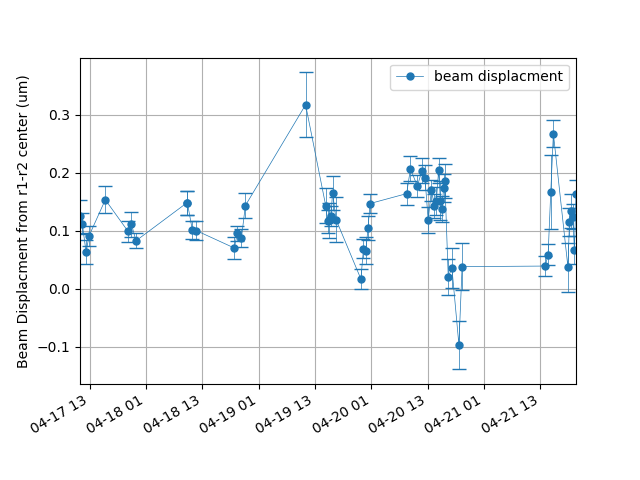

In [128]:
df4=pd.DataFrame({ "beam displacment": ratio_to_dist,'Max_error': dist_max_error,'Min_error': dist_min_error},index=startingtime)
ax=df4.plot(y=["beam displacment"],yerr=[dist_max_error,dist_min_error],capsize=5,lw=0.5,marker='o',markersize=5,color=['#1f77b4', '#d62728'])
ax.set_ylabel('Beam Displacment from r1-r2 center (um)')
ax.grid()

<IPython.core.display.Javascript object>


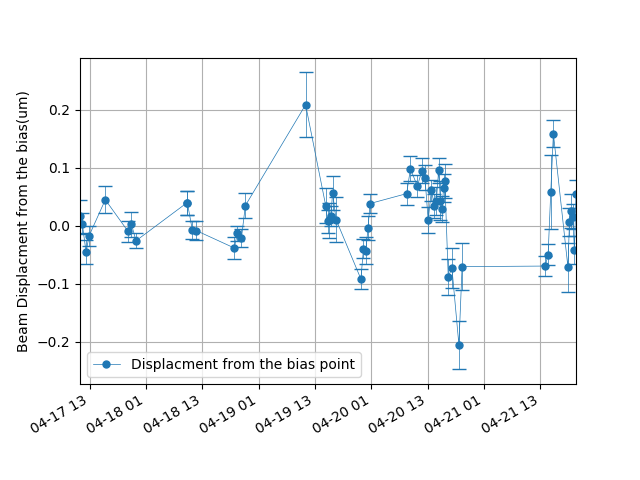

In [129]:
start_offset=np.mean(ratio_to_dist[0:5]) # Off
displacement_frombias=ratio_to_dist-start_offset
df5=pd.DataFrame({"Displacment from the bias point":displacement_frombias ,'Max_error': dist_max_error,'Min_error': dist_min_error},index=startingtime)
ax=df5.plot(y=["Displacment from the bias point"],yerr=[dist_max_error,dist_min_error],capsize=5,lw=0.5,marker='o',markersize=5,color=['#1f77b4', '#d62728'])
ax.set_ylabel('Beam Displacment from the bias(um)')
ax.grid()

In [114]:
np.std(displacement_frombias)

0.06432477732346421

<IPython.core.display.Javascript object>


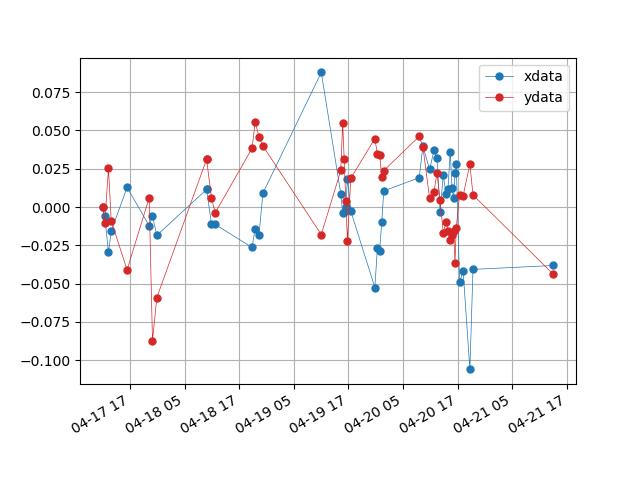

<IPython.core.display.Javascript object>


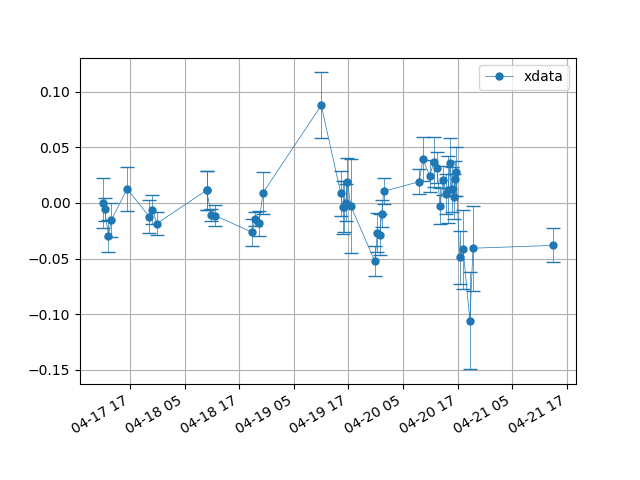

<IPython.core.display.Javascript object>


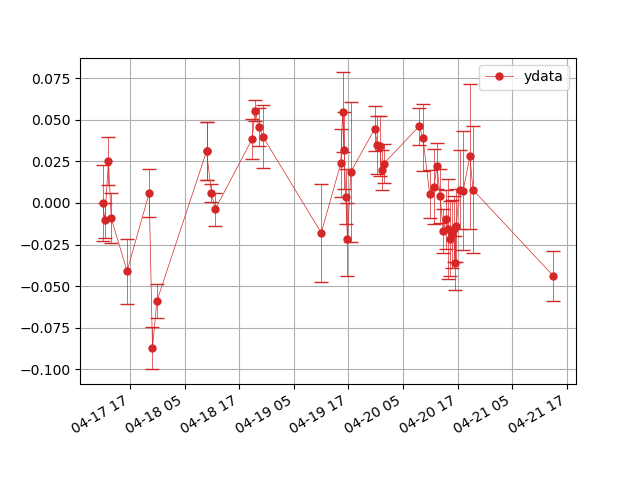

<IPython.core.display.Javascript object>


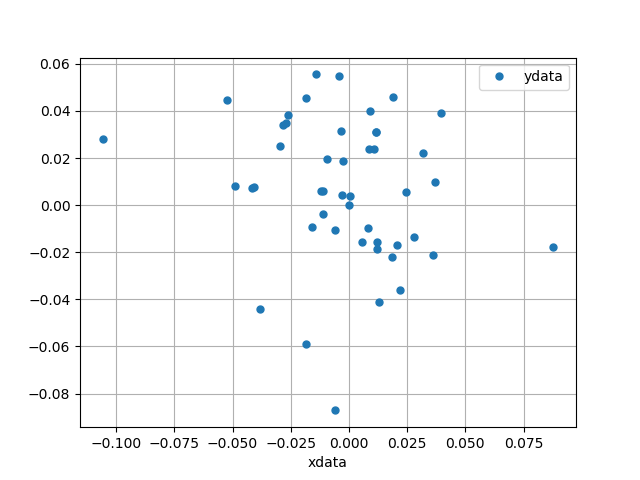

In [107]:
ratio_data=[]
ratio_error=[]
avetimestamp=[]
timelength=[]
startingtime=[]
x_data=[]
y_data=[]
x_error=[]
y_error=[]

for i in range(0,len(assorted['exp_ids'])):
    startingtime.append(dt.datetime.fromtimestamp(assorted['timestamps'][i][0]))
    x_data.append(0.5*(data11[i][2]/data11[0][2]-data11[i][4]/data11[0][4]))
    y_data.append((0.5*(data11[i][2]/data11[0][2]+data11[i][4]/data11[0][4]))-1.0)
    xerror=np.sqrt((1/data11[0][2]*data11[i][3])**2+(((-1/data11[0][4])*data11[i][3])**2))
    yerror=np.sqrt((1/data11[0][2]*data11[i][3])**2+(((1/data11[0][4])*data11[i][3])**2))
    x_error.append(xerror)
    y_error.append(yerror)
    avetimestamp.append(data11[i][6])
    
df=pd.DataFrame({  "xdata": x_data, "ydata": y_data,'timestamps': avetimestamp,'xerror': x_error,'yerror': y_error},index=startingtime)
ax=df.plot(y=[ "xdata","ydata"],lw=0.5,marker='o',markersize=5,color=[ '#1f77b4','#d62728'])
ax.grid()
ax=df.plot(y=[ "xdata"],yerr='xerror',capsize=5,lw=0.5,marker='o',markersize=5,color=['#1f77b4', '#d62728'])
ax.grid()
ax=df.plot(y=[ "ydata"],yerr='yerror',capsize=5,lw=0.5,marker='o',markersize=5,color=[ '#d62728'])
ax.grid()
ax=df.plot(x=[ "xdata"],y=["ydata"],lw=0,marker='.',markersize=10,color=[ '#1f77b4','#d62728'])
ax.grid()

# TIME SERIES ANALYSES

In [111]:
keylist=['Red_camera_dataX',
 'Red_camera_dataY',
  'FORT_camera_dataX',
'FORT_camera_dataY',
         'AAS_redside',
         'AAS_blueside',
 'timestamp_measurements',
 'timestamp_iteration']

# Closed Loop dataset
exp_ids=['2018_04_17_10_58_11_780A Ramsey between r1-r2',
         '2018_04_17_11_26_58_780A Ramsey between r1-r2',
         '2018_04_17_12_16_21_780A Ramsey between r1-r2',
         '2018_04_17_12_52_32_780A Ramsey between r1-r2',
         '2018_04_17_16_21_34_780A ramsey',
         '2018_04_17_21_12_34_780A ramsey',
         '2018_04_17_21_56_12_780A ramsey',
         '2018_04_17_22_53_53_780A ramsey',
         '2018_04_18_09_49_23_780A ramsey',
         '2018_04_18_09_49_23_780A ramsey',
         '2018_04_18_10_54_00_780A ramsey',
         '2018_04_18_11_42_28_780A ramsey',
         '2018_04_18_19_49_00_780A ramsey, closed loop',
         '2018_04_18_20_29_56_780A ramsey, closed loop',
         '2018_04_18_21_20_52_780A ramsey, closed loop',
         '2018_04_18_22_11_27_780A ramsey, closed loop',
         '2018_04_19_11_01_05_780A ramsey, closed loop',
         '2018_04_19_15_18_27_780A ramsey, closed loop',
         '2018_04_19_15_43_07_780A ramsey, closed loop',
         '2018_04_19_16_03_22_780A ramsey, closed loop',
         '2018_04_19_16_23_37_780A ramsey, closed loop',
         '2018_04_19_16_46_21_780A ramsey, closed loop',
         '2018_04_19_17_30_17_780A ramsey, closed loop',
         '2018_04_19_22_47_43_780A ramsey, closed loop',
         '2018_04_19_23_20_45_780A ramsey, closed loop',
         '2018_04_19_23_50_26_780A ramsey, closed loop',
         '2018_04_20_00_18_45_780A ramsey, closed loop',
         '2018_04_20_00_44_51_780A ramsey, closed loop',
#          '2018_04_20_02_03_45_780A ramsey, closed loop',
         '2018_04_20_08_32_02_780A ramsey, closed loop',
         '2018_04_20_09_20_41_780A ramsey, closed loop',
         '2018_04_20_10_49_28_780A ramsey, closed loop',
         '2018_04_20_11_47_15_780A ramsey, closed loop',
         '2018_04_20_12_26_31_780A ramsey, closed loop',
         '2018_04_20_13_07_25_780A ramsey, closed loop',
         '2018_04_20_13_49_08_780A ramsey, closed loop',
         '2018_04_20_14_27_42_780A ramsey, closed loop',
         '2018_04_20_14_51_43_780A ramsey, closed loop',
         '2018_04_20_15_21_04_780A ramsey, closed loop',
         '2018_04_20_15_44_45_780A ramsey, closed loop',
         '2018_04_20_16_05_33_780A ramsey, closed loop',
         '2018_04_20_16_23_49_780A ramsey, closed loop',
         '2018_04_20_16_40_40_780A ramsey, closed loop',
         '2018_04_20_17_23_53_780A ramsey, closed loop',
         '2018_04_20_18_10_59_780A ramsey, closed loop',
         '2018_04_20_19_40_13_780A ramsey, closed loop',
         '2018_04_20_20_20_52_780A ramsey, closed loop',
         '2018_04_21_14_01_47_780A ramsey, closed loop',
         '2018_04_21_14_39_59_780A ramsey, closed loop',
         '2018_04_21_15_14_06_780A ramsey, closed loop',
         '2018_04_21_15_47_33_780A ramsey, closed loop',
         '2018_04_21_18_53_41_780A ramsey, closed loop',
         '2018_04_21_19_12_49_780A ramsey, closed loop',
         '2018_04_21_19_33_26_780A ramsey, closed loop',
         '2018_04_21_19_55_13_780A ramsey, closed loop',
         '2018_04_21_20_16_19_780A ramsey, closed loop',
         '2018_04_21_20_36_32_780A ramsey, closed loop'        
         
        ]    
data={}
for j in range(0,len(exp_ids)):
    exp_id=exp_ids[j]
    q=open_data(exp_id)
    e=0
    for i in q.experiments[e]['iterations']:
        for key in keylist:
            if i==0 and j==0:
                data[key]=[]
            try:
                data[key].append(q.experiments[e]['iterations'][i][key])
            except:
                print "error occured : exp {}, iter {}, key {}".format(exp_id, i, key)
    

Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_17/2018_04_17_10_58_11_780A Ramsey between r1-r2/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_17/2018_04_17_11_26_58_780A Ramsey between r1-r2/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_17/2018_04_17_12_16_21_780A Ramsey between r1-r2/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_17/2018_04_17_12_52_32_780A Ramsey between r1-r2/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_17/2018_04_17_16_21_34_780A ramsey/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_17/2018_04_17_21_12_34_780A ramsey/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_17/2018_04_17_21_56_12_780A ramsey/qdp.txt

<IPython.core.display.Javascript object>


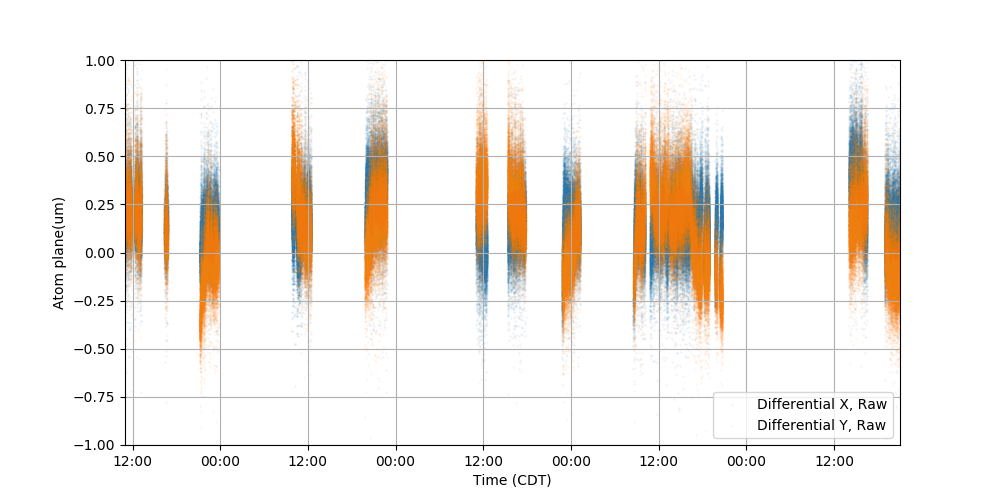

In [112]:
savefig=False
data_cutoff=0
xfmt=md.DateFormatter('%H:%M')
figW=10
figH=5
fig, ax = plt.subplots()
fig.set_size_inches(figW,figH)
flattendedtimestamps=np.array(flatten(data['timestamp_measurements']))
dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps][data_cutoff:]

flatteneddata0=np.array(flatten(data[keylist[0]]))[data_cutoff:]
flatteneddata2=np.array(flatten(data[keylist[2]]))[data_cutoff:]
flatteneddata1=np.array(flatten(data[keylist[1]]))[data_cutoff:]
flatteneddata3=np.array(flatten(data[keylist[3]]))[data_cutoff:]

ax.xaxis.set_major_formatter(xfmt)
data_to_plot=flatteneddata0-flatteneddata2-(flatteneddata0[0]-flatteneddata2[0])
ax.scatter(dates,data_to_plot,s=0.2,alpha=0.1,label='Differential X, Raw')
ax.set_xlim(dates[0],dates[-1])
ax.set_ylim(-1,1)

data_to_plot2=flatteneddata1-flatteneddata3-(flatteneddata1[0]-flatteneddata3[0])
ax.scatter(dates,data_to_plot2,s=0.2,alpha=0.1,label='Differential Y, Raw')
ax.grid()
ax.set_xlabel('Time (CDT)')
ax.set_ylabel('Atom plane(um)')
ax.legend()
if savefig:
    plt.savefig('Alignment_over_night.png')

330
455
868
993


<IPython.core.display.Javascript object>


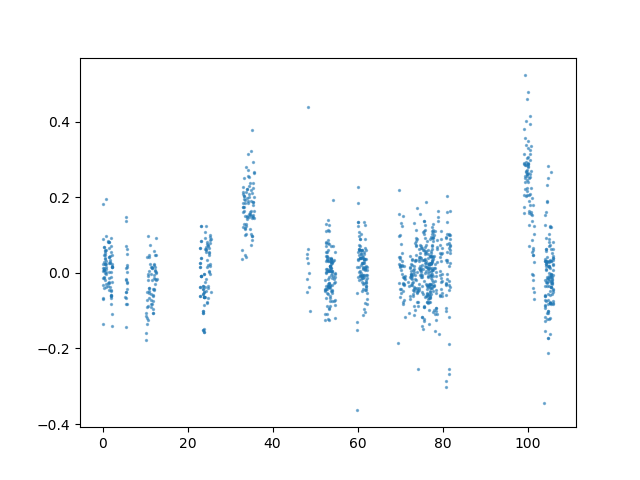

In [182]:
testing_list=[]
calibration_factor=12.0
elapsed_time_in_hours=np.array(data['timestamp_iteration'])/3600.0-np.array(data['timestamp_iteration'][0])/3600.0
for i in range(0,len(data[keylist[4]])):
    try:
        testing_list.append(data[keylist[4]][i]['error_x']/calibration_factor)
    except:
        print i
        testing_list.append(np.nan)
        
fig, ax = plt.subplots()
ax.scatter(elapsed_time_in_hours,testing_list,alpha=0.5,s=2)
#plt.plot(elapsed_time_in_hours,testing_list)
# plt.show()

<IPython.core.display.Javascript object>


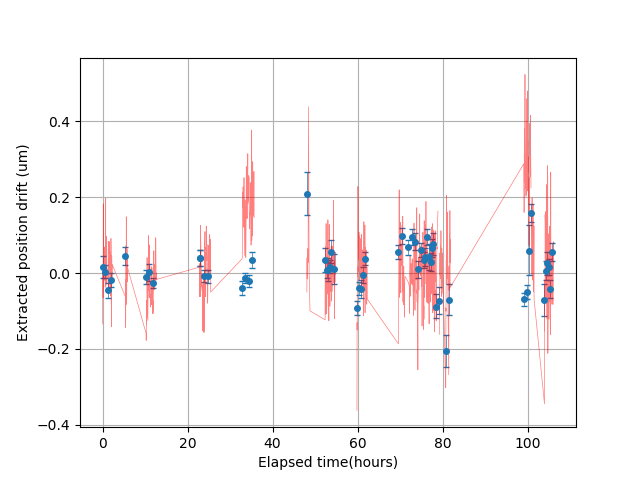

In [144]:
# this from qtom analysis

timediff=(startingtime_in_UNIX-startingtime_in_UNIX[0])/(3600)
fig, ax = plt.subplots()
ax.errorbar(timediff,displacement_frombias,yerr=[dist_max_error,dist_min_error],capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
ax.plot(elapsed_time_in_hours,testing_list,alpha=0.5,color='red',lw=0.5)
ax.set_xlabel('Elapsed time(hours)')
ax.set_ylabel('Extracted position drift (um)')
ax.grid()

# start_offset=np.mean(ratio_to_dist[0:5]) # Off
# displacement_frombias=ratio_to_dist-start_offset
# df5=pd.DataFrame({"Displacment from the bias point":displacement_frombias ,'Max_error': dist_max_error,'Min_error': dist_min_error},index=startingtime)
# ax=df5.plot(y=["Displacment from the bias point"],yerr=[dist_max_error,dist_min_error],capsize=5,lw=0.5,marker='o',markersize=5,color=['#1f77b4', '#d62728'])
# ax.set_ylabel('Beam Displacment from the bias(um)')
# ax.grid()